# Project: Multi-Modal Data Fusion Physical Exercise Classification


This project explores multi-modal data fusion techniques for classifying physical exercises using wearable sensor data and depth camera recordings. The study applies various methodologies covered during the course to perform user-independent exercise recognition.

The Open MEx dataset from the UCI Machine Learning Repository serves as the primary dataset. Additionally, an optional task involves experimenting with alternative approaches to identify individuals based on the same dataset.

The project aims to demonstrate the effectiveness of different feature extraction, fusion, and classification strategies for multi-modal time-series and image data.



---


### Author
Name: Vinicius Pozzobon Borin

Contact: borin.vini@gmail.com


---



## Description

This project focuses on developing user-independent pre-processing and classification models to recognize seven different physical exercises using data from an accelerometer (attached to the subject's thigh) and a depth camera (positioned above, capturing an aerial view). All exercises were performed with the subject lying on a mat.

The original MEx dataset from the UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/500/mex) includes additional modalities such as another acceleration sensor and a pressure-sensitive mat; however, these have been omitted in this project. The dataset contains 30 subjects, but a subset of 10 individuals is used in this work.

The project follows a structured approach divided into the following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification
4. Decision-level fusion for multimodal classification

Throughout these phases, data is analyzed and visualized, and results are documented with descriptive text and figures alongside the implementation. The models are evaluated using confusion matrices and F1 scores, where the macro F1 score is computed as:
<br>
<br>
$
\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}
$
<br>
<br>
where $F1_i = 2  \frac{precision_i * recall_i}{precision_i + recall_i}$, and $N$ is the number of classes.
<br>

## Objetives

By the end of this project, the following outcomes should be achieved:


*   Effective analysis of real-world multi-modal data
*   Application of different data fusion techniques for classification
*   Evaluation and interpretation of classification results
*   Thorough documentation of findings and methodology


## References & Additional Resources

* Original dataset [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#)
* Related scientific article [MEx: Multi-modal Exercises Dataset for Human Activity Recognition](https://arxiv.org/pdf/1908.08992.pdf)

# 1. Data preparation, exploration, and visualization

<a id='part1'></a>
<div class=" alert alert-warning">
    <b>Part 1</b>

 The dataset is organized into multiple folders, each containing raw data files corresponding to a single exercise performed by an individual. Each file represents a single exercise session recorded using wearable accelerometers and a depth camera. In most cases, each folder contains one continuous sequence of a specific exercise. However, Exercise 4 is an exception, as it is performed in two different ways. Despite this variation, both sequences of Exercise 4 belong to the same class.
<br>
<br>
<p> The first step in preparing the dataset is to read the raw data files using the provided function. Since the exercise sequences are long, they must be segmented into shorter sequences to be used for training and testing. This is done using a windowing method, similar to the approach described in the related research article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition". Each long exercise sequence should be divided into 5-second windows, with an overlap of 3 seconds between consecutive windows.</p>
<br>
<p> The windowing process works as follows: starting from the beginning of an exercise sequence, extract 5 seconds of data (both acceleration and depth image data) based on timestamps. Next, shift the window 2 seconds forward and extract another 5-second segment. This process continues until the entire sequence has been segmented. As a result, each windowed segment will contain a 500 × 3 matrix of accelerometer data and a 5 × 192 matrix of depth image data. These segmented sequences will be used in the next phases of the project for training and evaluating classification models.</p>

</div>

In [ ]:
# ============================================================
# Author: Vinicius Pozzobon Borin
# Date: 16/01/2025
# Version: 1.0
# ============================================================

# Import relevant libraries here
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve

import seaborn as sns
import matplotlib.pyplot as plt
import cupy as cp
import time

In [ ]:
# Set the flag to True if you want to mount Google Drive, False otherwise
MOUNT_GOOGLE_DRIVE = False  # Change this to True when you need to use Google Drive

if MOUNT_GOOGLE_DRIVE:
    import os
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive')

    # Define the path to your data folder on Google Drive
    loc = "/content/drive/MyDrive/MEx"  # Example path

    # Verify that the folder exists (optional but good practice)
    if os.path.exists(loc):
        print(f"Data folder found at: {loc}")
    else:
        print(f"ERROR: Data folder not found at {loc}. Please check the path.")

else:
    # Enter data folder location (local)
    loc = "./MEx"

Mounted at /content/drive
Data folder found at: /content/drive/MyDrive/MEx


In [ ]:
def path_to_meta(p):
    meta = dict()
    meta["subject_id"] = p.parent.stem
    meta["exercise_id"] = p.stem.split("_")[-2]
    meta["trial"] = int(p.stem.split("_")[-1])
    meta["sensor_code"] = p.stem.split("_")[0]
    meta["sensor"] = {"act": "acc", "dc": "dc"}[meta["sensor_code"]]
    return meta

# Find, read, and compose the measurements
paths_record = Path(loc).glob("*/*/*.csv")

records = []

for path_record in paths_record:
    df = pd.read_csv(path_record, delimiter=",", header=None)
    meta = path_to_meta(path_record)

    if meta["sensor"] == "acc":
        col_names = ["time", "acc_0", "acc_1", "acc_2"]
        df.columns = col_names
    else:
        num_cols = df.shape[1]
        col_names = ["time", ] + [f"dc_{i}" for i in range(num_cols-1)]
        df.columns = col_names

    meta["df"] = df

    records.append(meta)

df_records = pd.DataFrame.from_records(records)

print(f"Total records found: {len(df_records)}")
print("Dataframe with all records:")
display(df_records.head())
print("Dataframe with one measurement series:")
display(df_records["df"].iloc[0].head())

# Save df_records to a CSV file
df_records = pd.DataFrame.from_records(records)
df_records.to_csv("df_records.csv", index=False)

Total records found: 160
Dataframe with all records:


,subject_id,exercise_id,trial,sensor_code,sensor,df
0,06,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
1,06,06,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
2,06,04,2,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
3,06,05,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
4,06,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...


Dataframe with one measurement series:


,time,dc_0,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,...,dc_182,dc_183,dc_184,dc_185,dc_186,dc_187,dc_188,dc_189,dc_190,dc_191
0,0.0,0.4279,0.8617,0.8617,0.8587,0.8587,0.8587,0.8587,0.8573,0.8558,...,0.9410,0.9410,0.8122,0.9382,0.9372,0.9342,0.9342,0.9365,0.9333,0.9097
1,1000.0,0.4271,0.8617,0.8610,0.8587,0.8587,0.8580,0.8587,0.8565,0.8558,...,0.9401,0.9391,0.6093,0.9391,0.9372,0.9372,0.9342,0.9365,0.9324,0.9090
2,2000.0,0.4279,0.8617,0.8610,0.8587,0.8587,0.8580,0.8587,0.8573,0.8551,...,0.9410,0.9401,0.8122,0.9391,0.9372,0.9342,0.9342,0.9372,0.9342,0.9090
3,3000.0,0.4279,0.8617,0.8610,0.8587,0.8587,0.8587,0.8587,0.8573,0.8558,...,0.9401,0.9410,0.8122,0.9372,0.9357,0.9349,0.9342,0.9349,0.9324,0.9090
4,4000.0,0.4264,0.8617,0.8610,0.8587,0.8587,0.8587,0.8587,0.8580,0.8558,...,0.9401,0.9410,0.8135,0.9372,0.9365,0.9365,0.9342,0.9365,0.9333,0.9090


In [ ]:
# Extract 5-second long windows with 2-second shift (3-second overlap)

records_windowed = []

time_window = 5000.
time_offset = 2000.

for row_idx, row_data in df_records.iterrows():
    df_tmp = row_data["df"]
    time_start = np.min(df_tmp["time"].to_numpy())
    time_end = np.max(df_tmp["time"].to_numpy())

    for window_idx, t0 in enumerate(np.arange(time_start, time_end, time_offset)):
        t1 = t0 + time_window
        # Handle boundary conditions - skip the measurements from the end shorter than window size
        if t1 > time_end:
            continue

        tmp_data = deepcopy(row_data)
        tmp_data["window_idx"] = window_idx
        tmp_data["df"] = df_tmp[(df_tmp["time"] >= t0) &
                                (df_tmp["time"] < t1)].copy()

        records_windowed.append(tmp_data)

df_records_windowed = pd.DataFrame.from_records(records_windowed)

print(f"Total windows extracted: {len(df_records_windowed)}")
print("Dataframe with all windowed records:")
display(df_records_windowed.head())
print("Dataframe with one windowed measurement series:")
display(df_records_windowed["df"].iloc[0].head())

# Save df_records to a CSV file
#df_records_windowed.to_csv("df_records_window.csv", index=False)

Total windows extracted: 4169
Dataframe with all windowed records:


,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
0,06,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 d...,0
1,06,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 d...,1
2,06,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 d...,2
3,06,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,3
4,06,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,4


Dataframe with one windowed measurement series:


,time,dc_0,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,...,dc_182,dc_183,dc_184,dc_185,dc_186,dc_187,dc_188,dc_189,dc_190,dc_191
0,0.0,0.4279,0.8617,0.8617,0.8587,0.8587,0.8587,0.8587,0.8573,0.8558,...,0.9410,0.9410,0.8122,0.9382,0.9372,0.9342,0.9342,0.9365,0.9333,0.9097
1,1000.0,0.4271,0.8617,0.8610,0.8587,0.8587,0.8580,0.8587,0.8565,0.8558,...,0.9401,0.9391,0.6093,0.9391,0.9372,0.9372,0.9342,0.9365,0.9324,0.9090
2,2000.0,0.4279,0.8617,0.8610,0.8587,0.8587,0.8580,0.8587,0.8573,0.8551,...,0.9410,0.9401,0.8122,0.9391,0.9372,0.9342,0.9342,0.9372,0.9342,0.9090
3,3000.0,0.4279,0.8617,0.8610,0.8587,0.8587,0.8587,0.8587,0.8573,0.8558,...,0.9401,0.9410,0.8122,0.9372,0.9357,0.9349,0.9342,0.9349,0.9324,0.9090
4,4000.0,0.4264,0.8617,0.8610,0.8587,0.8587,0.8587,0.8587,0.8580,0.8558,...,0.9401,0.9410,0.8135,0.9372,0.9365,0.9365,0.9342,0.9365,0.9333,0.9090


<a id='part1'></a>
<div class=" alert alert-warning">
     
<p> <b>1.1</b> In this section, we will visualize representative examples of the preprocessed data for each modality, including accelerometer and depth camera recordings. We will plot the accelerometer sensor data as a multi-dimensional time-series and represent the depth camera data as a 2D image. Specifically, we will generate plots for 5-second sequences of accelerometer and depth camera data for subjects 1 and 5, performing exercises 2, 5, and 6. For each case, we will use the first windowed segment extracted from the corresponding long exercise sequence. </p>

</div>

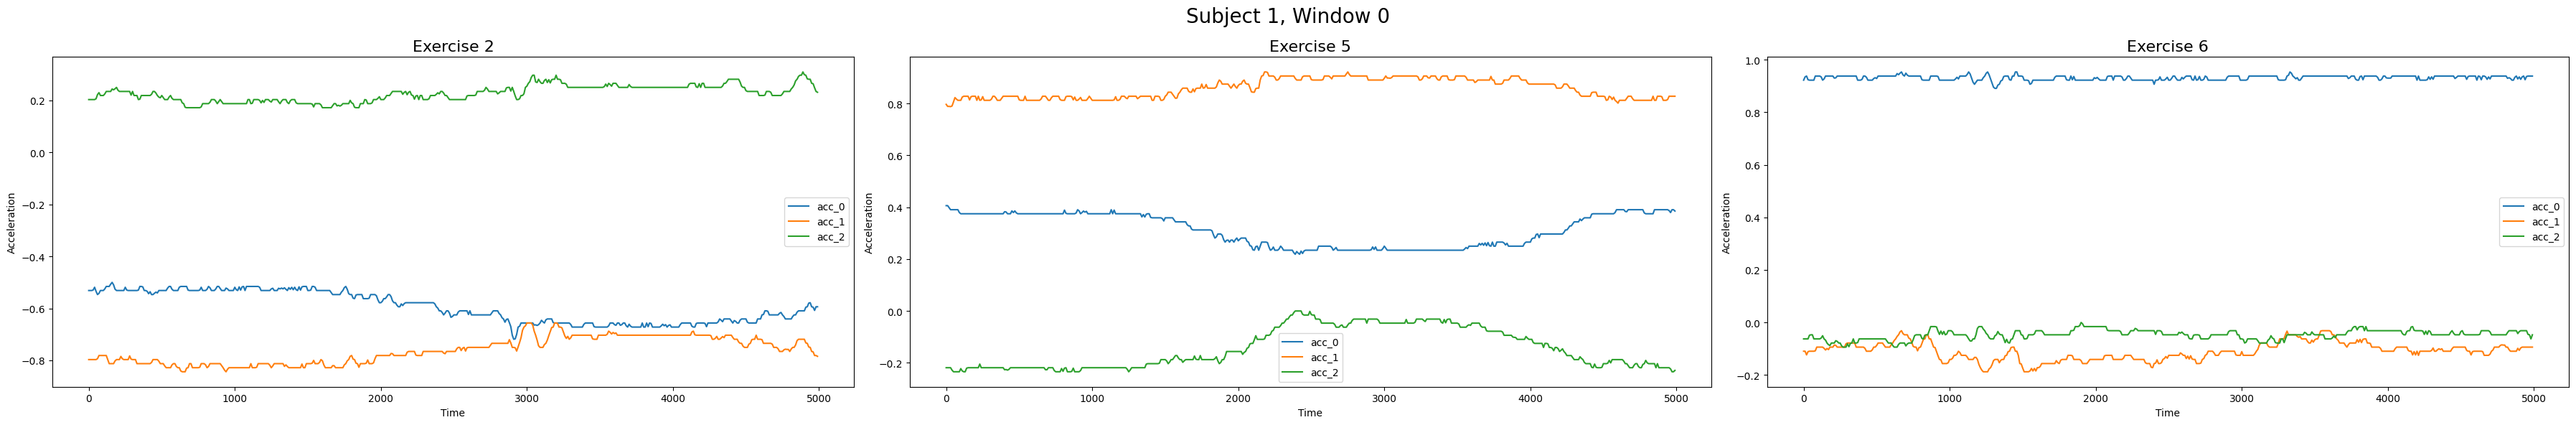

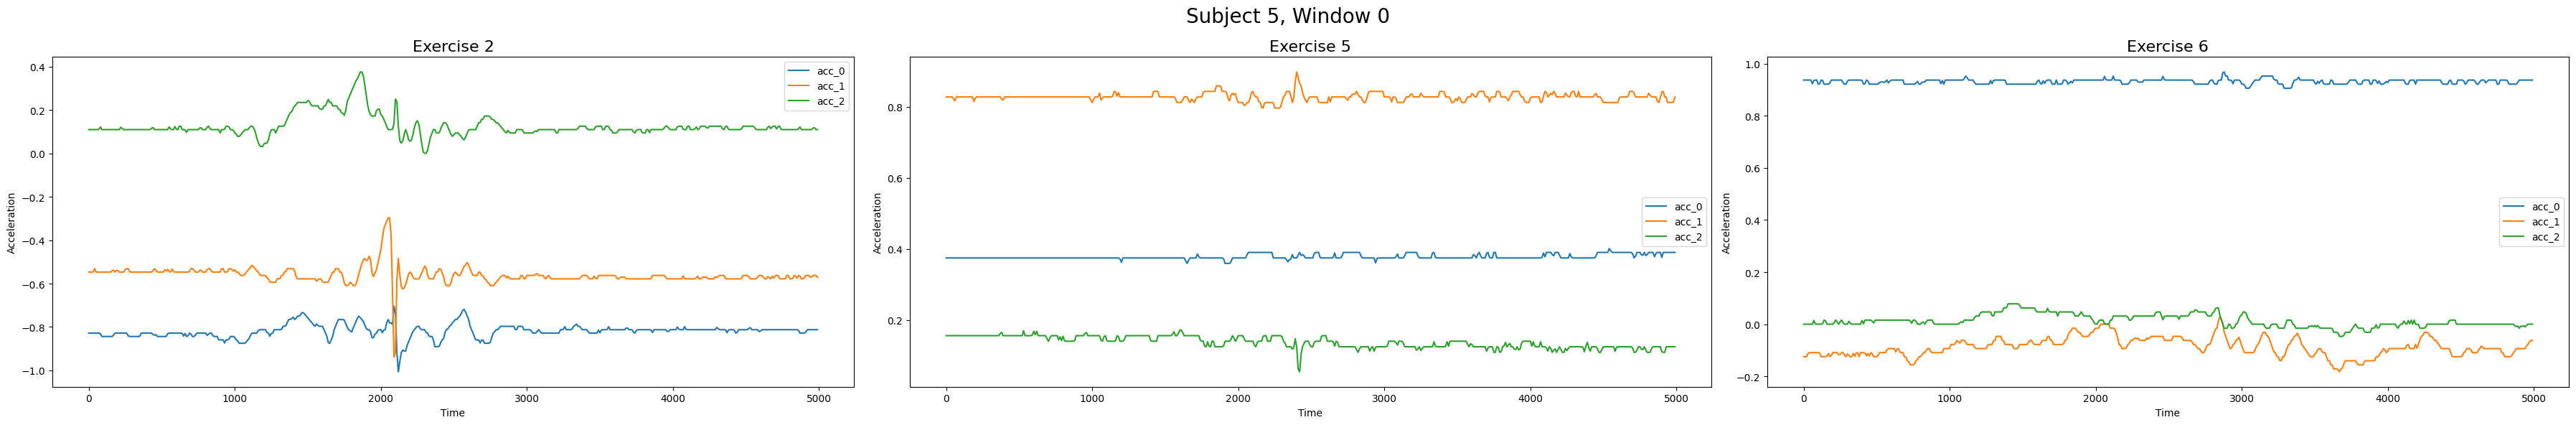

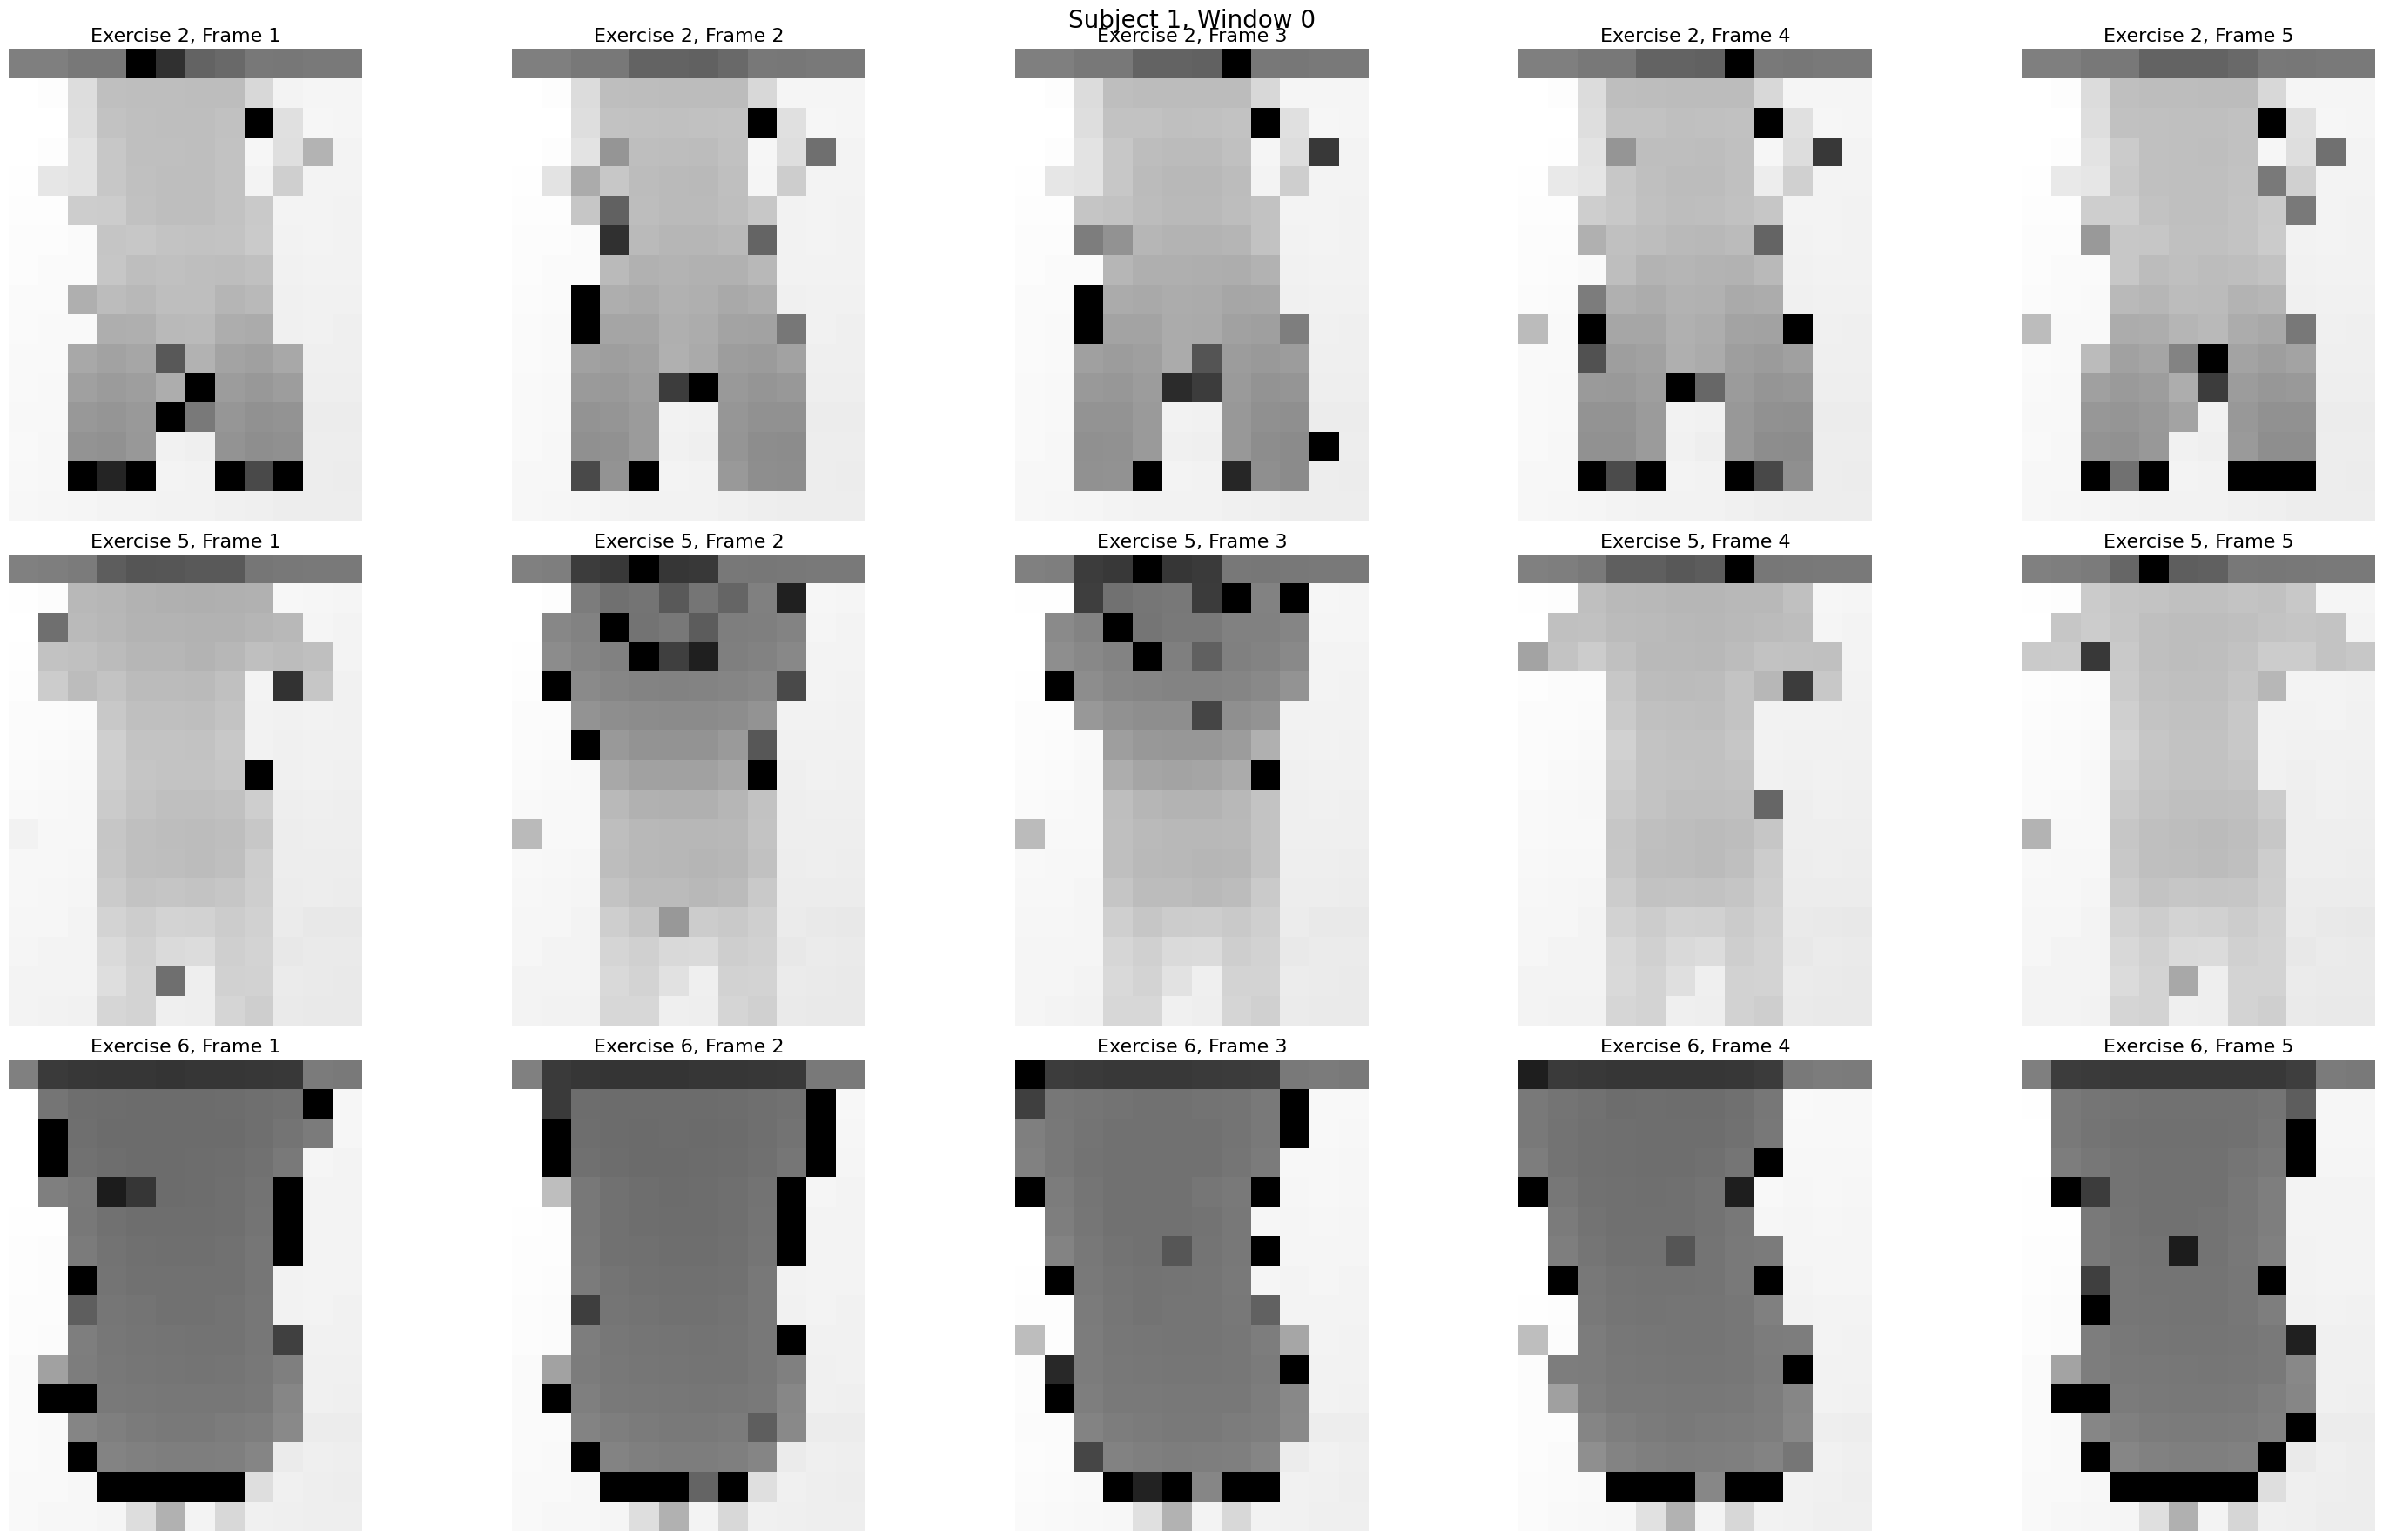

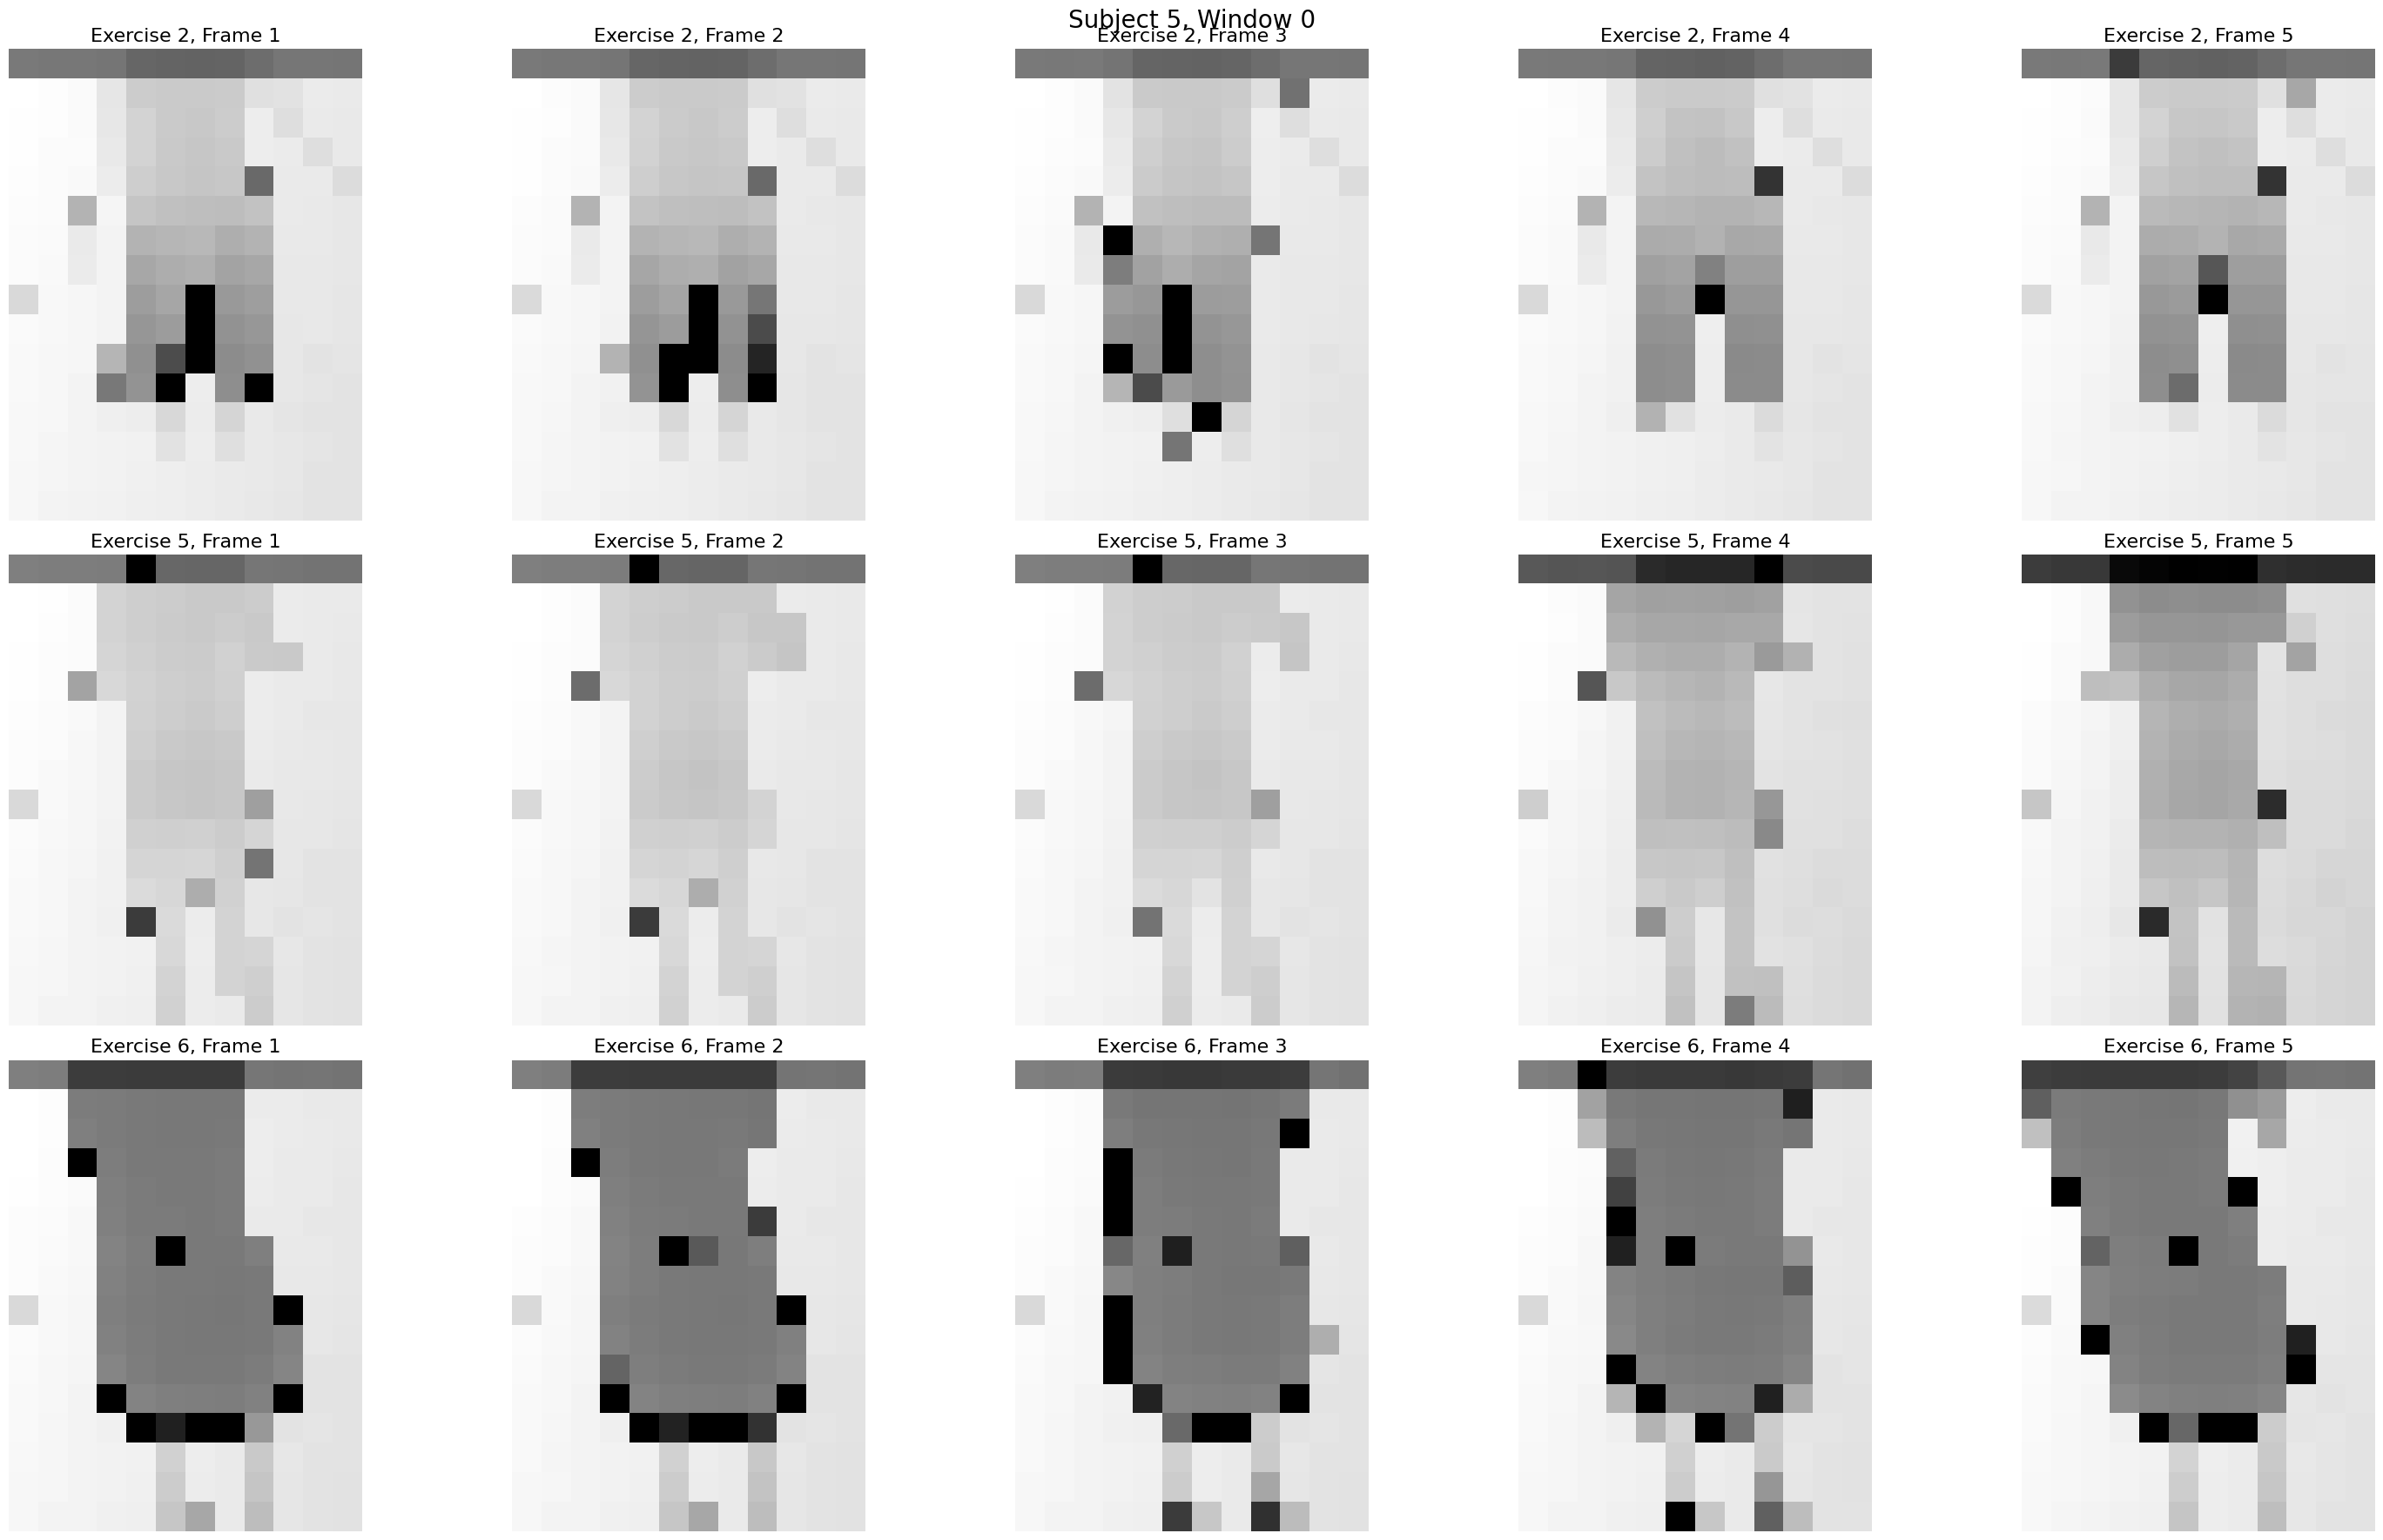

In [ ]:
# 1.1. Visualize selected samples for both modalities

def plot_acc_data(df_records_windowed, subject_id, exercise_ids, window_idx=0):
    """
    Plots accelerometer data for a specific subject and multiple exercises,
    with each exercise's data in a separate subplot, arranged in a single row.

    Args:
      df_records_windowed: DataFrame containing windowed records.
      subject_id: ID of the subject.
      exercise_ids: List of exercise IDs to plot.
      window_idx: Index of the window to plot (default: 0).
    """

    num_exercises = len(exercise_ids)

    fig, axes = plt.subplots(1, num_exercises, figsize=(12 * num_exercises, 6))
    fig.suptitle(f"Subject {subject_id}, Window {window_idx}", fontsize=20)

    for i, exercise_id in enumerate(exercise_ids):
        # Filter data for the specific subject, exercise, and window
        df_filtered = df_records_windowed[
            (df_records_windowed["subject_id"] == str(subject_id))
            & (df_records_windowed["exercise_id"] == str(exercise_id))
            & (df_records_windowed["window_idx"] == window_idx)
        ]

        for j, row in df_filtered.iterrows():
            sensor = row["sensor"]
            df = row["df"]
            if sensor == "acc":
                # Plot accelerometer data on the corresponding subplot
                axes[i].plot(df["time"], df["acc_0"], label=f"acc_0")
                axes[i].plot(df["time"], df["acc_1"], label=f"acc_1")
                axes[i].plot(df["time"], df["acc_2"], label=f"acc_2")
                axes[i].set_xlabel("Time")
                axes[i].set_ylabel("Acceleration")
                axes[i].set_title(f"Exercise {exercise_id}", fontsize=16)
                axes[i].legend()

    plt.tight_layout()
    plt.show()


def plot_dc_data(df_records_windowed, subject_id, exercise_ids, window_idx=0):
    """
    Plots depth camera images for a specific subject and multiple exercises,
    with each exercise's images in a separate row of subplots.

    Args:
      df_records_windowed: DataFrame containing windowed records.
      subject_id: ID of the subject.
      exercise_ids: List of exercise IDs to plot.
      window_idx: Index of the window to plot (default: 0).
    """

    num_exercises = len(exercise_ids)
    frames_per_exercise = 5  # Number of frames per exercise

    # Create subplots with one row per exercise
    fig, axes = plt.subplots(num_exercises, frames_per_exercise, figsize=(6 * frames_per_exercise, 6 * num_exercises))
    fig.suptitle(f"Subject {subject_id}, Window {window_idx}", fontsize=20)

    for i, exercise_id in enumerate(exercise_ids):
        # Filter data for the specific subject, exercise, and window
        df_filtered = df_records_windowed[
            (df_records_windowed["subject_id"] == str(subject_id))
            & (df_records_windowed["exercise_id"] == str(exercise_id))
            & (df_records_windowed["window_idx"] == window_idx)
        ]

        for j, row in df_filtered.iterrows():
            sensor = row["sensor"]
            df = row["df"]
            if sensor == "dc":
                # Reshape the 1D data into frames
                frames = df.drop(columns=["time"]).values.reshape(5, 1, 12, 16)

                # Plot each frame in a separate subplot in the current row
                for k, frame in enumerate(frames):
                    ax = axes[i, k]  # Access subplot using [row, col] indexing

                    # Rotate the frame -90 degrees
                    rotated_frame = np.rot90(frame.squeeze(), k=-1)

                    ax.imshow(rotated_frame, cmap="gray")
                    ax.set_title(f"Exercise {exercise_id}, Frame {k+1}", fontsize=16)
                    ax.axis("off")

    plt.tight_layout()
    plt.show()


"""
    MAIN CODE
"""
# Remove zeros in front of the ids
df_records_windowed["subject_id"] = df_records_windowed["subject_id"].astype(str).str.lstrip("0")
df_records_windowed["exercise_id"] = df_records_windowed["exercise_id"].astype(str).str.lstrip("0")

# Plot data for specified subjects and exercises
subject_ids = [1, 5]
exercise_ids = [2, 5, 6]

for subject_id in subject_ids:
    plot_acc_data(df_records_windowed, subject_id, exercise_ids)

for subject_id in subject_ids:
    plot_dc_data(df_records_windowed, subject_id, exercise_ids)

<a id='part1'></a>
<div class=" alert alert-warning">

<p> <b>1.2</b> In this section, we will split the preprocessed dataset into training and testing sets. Data from subjects 1 to 7 will be used for training, while data from subjects 8 to 10 will be allocated for testing. In later tasks, the training dataset may be further divided into multiple validation folds to fine-tune model parameters when necessary.<br>
    
<p> The training set is expected to contain 1,486 windows, while the testing set should have 598 windows. Notably, within the training set, there is an unpaired window where accelerometer data lacks a corresponding depth camera entry. This window must be removed to ensure data consistency.<p>
  
To ensure proper documentation and understanding of the dataset, we will calculate key statistics for both training and testing sets, including the number of examples and the dimensionality of each data sample. Additionally, we will visualize representative examples from the prepared dataset.

</div>

In [ ]:
# 1.2. Split samples based on subject ID into training and testing datasets for futher experiments

# Data Splitting and Preprocessing:
# - The provided code splits the `df_records_windowed` DataFrame into training and testing sets based on subject ID.
# - Subjects 1-7 are assigned to the training set (df_train), and subjects 8-10 are assigned to the testing set (df_test).
# - An unpaired window in the training set (where there's no corresponding depth camera data for an accelerometer window) is identified and removed.

# Indicator Statistics:
# - Training set size: 1486 windows (after removing the unpaired window)
# - Testing set size: 598 windows
# - Dimensions of each example:
#   - Accelerometer data: 5 seconds of data with 3 axes (acc_0, acc_1, acc_2) sampled at 100 Hz, resulting in a shape of (500, 3).
#   - Depth camera data: 5 frames, each with dimensions of 12x16 pixels, resulting in a shape of (5, 12, 16).

# Split data into training and testing sets based on subject ID
df_train = df_records_windowed[df_records_windowed["subject_id"].isin(["1", "2", "3", "4", "5", "6", "7"])]
df_test = df_records_windowed[df_records_windowed["subject_id"].isin(["8", "9", "10"])]

# Identify and drop the unpaired window in the training set
train_counts = df_train.groupby(["subject_id", "exercise_id", "window_idx"]).size()
unpaired_window = train_counts[train_counts == 1].index[0]  # Get the index of the unpaired window

df_train = df_train.drop(
    df_train[
        (df_train["subject_id"] == unpaired_window[0])
        & (df_train["exercise_id"] == unpaired_window[1])
        & (df_train["window_idx"] == unpaired_window[2])
    ].index
)

# Verify the number of windows in each set
# I am dividind by 2 because acc and dc are in the same df. So each pair must count as 1 window, not 2.
print(f"Training set size: {len(df_train)/2}")  # Should print 1486
print(f"Testing set size: {len(df_test)/2}")  # Should print 598

#display(df_train[1400:1450].head())
#print(unpaired_window)

Training set size: 1486.0
Testing set size: 598.0


# 2. Feature extraction and fusion for unimodal classification

<a id='part2'></a>
<div class=" alert alert-warning">
    <b>Part 2</b>

In this section, we will use the training dataset prepared in Task 1 to develop models based on a combination of Principal Component Analysis (PCA), Linear Discriminant Analysis (LDA), and the Nearest Neighbor (NN) classifier for each modality separately. The trained models will then be evaluated on the test dataset.
<br>
<br>
<p> <b>2.1 Dimensionality Reduction and Classification for Accelerometer Data</b>

To reduce the dimensionality of accelerometer data, we will apply PCA and LDA transformations. Prior to these transformations, the data will be downsampled from 100 Hz to 25 Hz using scipy.signal.resample, resulting in a 125 × 3 matrix for each 5-second window. Additionally, the data will be standardized to have zero mean and unit variance before performing the transformations.

Using the training dataset, we will: </p>

*   Fit PCA with a 5-dimensional subspace, selecting the five largest principal components.
*   Fit LDA with a 5-dimensional subspace.
*   Transform both training and testing examples into this low-dimensional feature representation.
*   Concatenate each sequence into a single vector of size 3 × (5 + 5).
*   Perform fusion of PCA and LDA in a similar manner to the approach presented in Lecture 3 (pages 24-25), using the Nearest Neighbor (NN) method for classification.
*   Evaluate the model performance on the test set.

<br>

The results will be analyzed using a confusion matrix and F1 scores to assess classification accuracy. Additionally, all data standardization will be performed along each axis.
    
</div>

In [ ]:
##### PART 1 - resample to 12x3 and standardize #####

# Resample accelerometer data to 125 samples per window
def resample_accelerometer_data(df, original_hz=100, target_hz=25, window_size_sec=5):
    """Resamples accelerometer data within a DataFrame from original_hz to target_hz.

    Args:
        df: The input DataFrame. It should be df_records_windowed.
        original_hz: Original sampling rate of accelerometer data.
        target_hz: Target sampling rate for downsampling.
        window_size_sec: The size of the window in seconds.

    Returns:
        A DataFrame with resampled accelerometer data.
    """

    # Calculate the number of samples in the original and target windows
    original_samples = int(original_hz * window_size_sec)
    target_samples = int(target_hz * window_size_sec)

    df_copy = df.copy()
    resampled_dfs = []

    for index, row in df_copy.iterrows():
        if row["sensor"] == "acc":
            df_acc = row["df"].copy()

            # Resample each accelerometer column directly to 125 samples
            resampled_data = {}
            for col in ["acc_0", "acc_1", "acc_2"]:
                resampled_data[col] = resample(df_acc[col], target_samples)

            # Create a new DataFrame with the resampled data
            df_resampled_acc = pd.DataFrame(resampled_data)

            # Update the 'time' column
            df_resampled_acc["time"] = np.linspace(
                df_acc["time"].iloc[0], df_acc["time"].iloc[-1], target_samples
            )

            # Create a new row with the resampled DataFrame
            new_row = row.copy()
            new_row["df"] = df_resampled_acc  # Use the new df_resampled_acc
            resampled_dfs.append(new_row)
        else:
            resampled_dfs.append(row.copy())  # Keep depth camera data as is

    # Concatenate all the modified rows back into a single DataFrame
    df_resampled = pd.DataFrame(resampled_dfs)

    return df_resampled

# Standardize the values to zero mean and unit variance
def standardize_data(df_train, df_test):
    """Standardizes accelerometer data to zero mean and unit variance.

    Applies standardization to 'acc_0', 'acc_1', and 'acc_2' columns
    within the nested 'df' DataFrames for accelerometer sensor data.

    Args:
        df_train: The training DataFrame.
        df_test: The testing DataFrame.

    Returns:
        A tuple containing the standardized training DataFrame and the standardized
        testing DataFrame.
    """

    df_train_standardized = df_train.copy()
    df_test_standardized = df_test.copy()

    # Fit standardization parameters on the training data
    train_acc_data = []
    for index, row in df_train_standardized.iterrows():
        if row["sensor"] == "acc":
            train_acc_data.append(row["df"][["acc_0", "acc_1", "acc_2"]].values)
    train_acc_data = np.concatenate(train_acc_data, axis=0)

    mean = np.mean(train_acc_data, axis=0)
    std = np.std(train_acc_data, axis=0)

    # Apply standardization to training data
    for index, row in df_train_standardized.iterrows():
        if row["sensor"] == "acc":
            df_acc = row["df"].copy()
            df_acc[["acc_0", "acc_1", "acc_2"]] = (
                df_acc[["acc_0", "acc_1", "acc_2"]] - mean
            ) / std
            df_train_standardized.at[index, "df"] = df_acc

    # Apply standardization to testing data using training data parameters
    for index, row in df_test_standardized.iterrows():
        if row["sensor"] == "acc":
            df_acc = row["df"].copy()
            df_acc[["acc_0", "acc_1", "acc_2"]] = (
                df_acc[["acc_0", "acc_1", "acc_2"]] - mean
            ) / std
            df_test_standardized.at[index, "df"] = df_acc

    return df_train_standardized, df_test_standardized

In [ ]:
"""
    MAIN CODE
"""
# Apply resampling to the training set
df_train_resampled = resample_accelerometer_data(df_train)

# Apply resampling to the testing set
df_test_resampled = resample_accelerometer_data(df_test)

# Apply standardization ond train and test set
df_train_standardized, df_test_standardized = standardize_data(
    df_train_resampled, df_test_resampled
)

# --- Verification ---
# Verify the shape of the resampled data in one of the windows
sample_window_train = df_train_standardized[df_train_standardized["sensor"] == "acc"].iloc[0]["df"]
sample_window_test = df_test_standardized[df_test_standardized["sensor"] == "acc"].iloc[0]["df"]

print(f"Resampled accelerometer data shape (df_train - acc_0): {sample_window_train['acc_0'].shape}")
print(f"Resampled accelerometer data shape (df_train - acc_1): {sample_window_train['acc_1'].shape}")
print(f"Resampled accelerometer data shape (df_train - acc_2): {sample_window_train['acc_2'].shape}")
print(f"Resampled accelerometer data shape (df_test - acc_0): {sample_window_test['acc_0'].shape}")
print(f"Resampled accelerometer data shape (df_test - acc_1): {sample_window_test['acc_1'].shape}")
print(f"Resampled accelerometer data shape (df_test - acc_2): {sample_window_test['acc_2'].shape}")

# Verify the number of windows in each set
print(f"Training set size: {len(df_train_standardized)/2}")
print(f"Testing set size: {len(df_test_standardized)/2}")

# Print one acc data from df_train and one from resample
# Get a sample window from the original training data (before resampling)
sample_window_train_original = df_train[df_train["sensor"] == "acc"].iloc[0]["df"]

# Get the corresponding sample window from the resampled training data
sample_window_train_resampled = df_train_resampled[df_train_resampled["sensor"] == "acc"].iloc[0]["df"]

# Get the corresponding sample window from the standardized training data
sample_window_train_standardized = df_train_standardized[df_train_standardized["sensor"] == "acc"].iloc[0]["df"]

print("-" * 20)
print("Original 'acc_0' data (df_train):")
print(sample_window_train_original["acc_0"])
print("-" * 20)
print("Resampled 'acc_0' data (df_train_resampled):")
print(sample_window_train_resampled["acc_0"])
print("-" * 20)
print("Standardized 'acc_0' data (df_train_standardized):")
print(sample_window_train_standardized["acc_0"])
print("-" * 20)

# Check the mean and std of the standardized data (should be close to 0 and 1)
print(f"Mean of standardized 'acc_0' (training): {np.mean(sample_window_train_standardized['acc_0']):.4f}")
print(f"Std of standardized 'acc_0' (training): {np.std(sample_window_train_standardized['acc_0']):.4f}")

Resampled accelerometer data shape (df_train - acc_0): (125,)
Resampled accelerometer data shape (df_train - acc_1): (125,)
Resampled accelerometer data shape (df_train - acc_2): (125,)
Resampled accelerometer data shape (df_test - acc_0): (125,)
Resampled accelerometer data shape (df_test - acc_1): (125,)
Resampled accelerometer data shape (df_test - acc_2): (125,)
Training set size: 1486.0
Testing set size: 598.0
--------------------
Original 'acc_0' data (df_train):
0     -0.906250
1     -0.906250
2     -0.906250
3     -0.906250
4     -0.906250
         ...   
495   -0.890625
496   -0.890625
497   -0.890625
498   -0.890625
499   -0.890625
Name: acc_0, Length: 500, dtype: float64
--------------------
Resampled 'acc_0' data (df_train_resampled):
0     -0.900270
1     -0.907446
2     -0.906207
3     -0.897114
4     -0.888597
         ...   
120   -0.889186
121   -0.887615
122   -0.890950
123   -0.890879
124   -0.889593
Name: acc_0, Length: 125, dtype: float64
--------------------
Stand

In [ ]:
##### PART 2 - Dimensionality Reduction and CONCATENATE using PCA and LDA #####

# --- Dimensionality Reduction using PCA and LDA ---

def reduce_dimensionality(df_train, df_test, n_components_pca=5, n_components_lda=5):
    """
    Reduces the dimensionality of accelerometer data using PCA and LDA.

    Args:
        df_train: The standardized training DataFrame.
        df_test: The standardized testing DataFrame.
        n_components_pca: The number of principal components for PCA.
        n_components_lda: The number of components for LDA.

    Returns:
        A tuple containing the transformed training DataFrame and the transformed
        testing DataFrame, where each accelerometer window is represented by a
        concatenated vector of PCA and LDA components.
    """

    # Prepare data for PCA and LDA
    X_train = []
    y_train = []
    for index, row in df_train.iterrows():
        if row["sensor"] == "acc":
            X_train.append(
                row["df"][["acc_0", "acc_1", "acc_2"]].values.flatten()
            )  # Flatten each window to a 1D array
            y_train.append(row["exercise_id"])  # Assuming you want to use exercise_id for LDA
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = []
    for index, row in df_test.iterrows():
        if row["sensor"] == "acc":
            X_test.append(row["df"][["acc_0", "acc_1", "acc_2"]].values.flatten())
    X_test = np.array(X_test)

    # --- PCA ---
    pca = PCA(n_components=n_components_pca)
    pca.fit(X_train)  # Fit PCA on training data

    # Transform both training and testing data
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # --- LDA ---
    lda = LDA(n_components=n_components_lda)
    lda.fit(X_train, y_train)  # Fit LDA on training data

    # Transform both training and testing data
    X_train_lda = lda.transform(X_train)
    X_test_lda = lda.transform(X_test)

    # --- Concatenate PCA and LDA components ---
    X_train_combined = np.concatenate((X_train_pca, X_train_lda), axis=1)
    X_test_combined = np.concatenate((X_test_pca, X_test_lda), axis=1)

    # --- Update DataFrames ---
    df_train_transformed = df_train.copy()
    df_test_transformed = df_test.copy()

    train_idx = 0
    for index, row in df_train_transformed.iterrows():
      if row["sensor"] == "acc":
        df_train_transformed.at[index, "df"] = X_train_combined[train_idx, :]
        train_idx += 1

    test_idx = 0
    for index, row in df_test_transformed.iterrows():
      if row["sensor"] == "acc":
        df_test_transformed.at[index, "df"] = X_test_combined[test_idx, :]
        test_idx += 1

    return df_train_transformed, df_test_transformed

# --- Fusion of PCA and LDA ---
def fuse_and_classify(df_train_transformed, df_test_transformed):
    """
    Performs fusion of PCA and LDA representations and classifies test examples.

    Uses CuPy for GPU acceleration.

    Args:
        df_train_transformed: The transformed training DataFrame.
        df_test_transformed: The transformed testing DataFrame.

    Returns:
        A tuple containing:
            - y_true: True labels of the test set (as a NumPy array).
            - y_pred: Predicted labels for the test set (as a NumPy array).
    """

    y_true = []
    y_pred = []

    # Create a mapping from exercise_id to a unique integer label
    label_mapping = {label: i for i, label in enumerate(df_train_transformed['exercise_id'].unique())}

    # Move data to GPU
    print("Moving data to GPU...")
    start_time = time.time()
    df_train_gpu = df_train_transformed.copy()
    df_test_gpu = df_test_transformed.copy()

    for index, row in df_train_gpu.iterrows():
        if row["sensor"] == "acc":
            df_train_gpu.at[index, "df"] = cp.asarray(row["df"])

    for index, row in df_test_gpu.iterrows():
        if row["sensor"] == "acc":
            df_test_gpu.at[index, "df"] = cp.asarray(row["df"])
    print(f"Data moved to GPU in {time.time() - start_time:.4f} seconds")

    total_test_examples = len(df_test_gpu[df_test_gpu["sensor"] == "acc"])
    for test_index, test_row in df_test_gpu.iterrows():
        if test_row["sensor"] == "acc":
            test_data = test_row["df"]
            y_true.append(test_row["exercise_id"])

            min_dist = float("inf")
            predicted_label = None

            # Calculate distances on GPU
            print(f"Calculating distances for test example {len(y_pred) + 1}/{total_test_examples}...")
            start_time = time.time()

            pca_distances = []
            lda_distances = []
            for train_index, train_row in df_train_gpu.iterrows():
                if train_row["sensor"] == "acc":
                    train_data = train_row["df"]

                    pca_dist = cp.sum((test_data[:5] - train_data[:5]) ** 2)
                    lda_dist = cp.sum((test_data[5:] - train_data[5:]) ** 2)

                    pca_distances.append(pca_dist)
                    lda_distances.append(lda_dist)

            # Find min and max distances on GPU
            pca_distances = cp.array(pca_distances)
            lda_distances = cp.array(lda_distances)

            min_pca_dist = cp.min(pca_distances)
            max_pca_dist = cp.max(pca_distances)
            min_lda_dist = cp.min(lda_distances)
            max_lda_dist = cp.max(lda_distances)

            end_time = time.time()
            print(f"Distances calculated in {end_time - start_time:.4f} seconds")

            # Normalize and fuse distances on GPU
            print("Normalizing and fusing distances...")
            start_time = time.time()

            for train_index, train_row in df_train_gpu.iterrows():
                if train_row["sensor"] == "acc":
                    train_data = train_row["df"]

                    pca_dist = cp.sum((test_data[:5] - train_data[:5]) ** 2)
                    lda_dist = cp.sum((test_data[5:] - train_data[5:]) ** 2)

                    pca_dist_norm = (pca_dist - min_pca_dist) / (max_pca_dist - min_pca_dist)
                    lda_dist_norm = (lda_dist - min_lda_dist) / (max_lda_dist - min_lda_dist)
                    fused_dist = (pca_dist_norm + lda_dist_norm) / 2

                    # Update nearest neighbor
                    if fused_dist < min_dist:
                        min_dist = fused_dist
                        predicted_label = train_row["exercise_id"]

            # Convert predicted label to numerical label using the mapping
            predicted_label_numeric = label_mapping[predicted_label]
            y_pred.append(predicted_label_numeric)

            end_time = time.time()
            print(f"Normalization and fusion done in {end_time - start_time:.4f} seconds")
            print("-" * 20)

    return np.array(y_true), cp.asnumpy(cp.array(y_pred)), label_mapping  # Return label_mapping

Transformed training data shape: (10,)
Transformed testing data shape: (10,)
Training set size: 1486.0
Testing set size: 598.0
Moving data to GPU...
Data moved to GPU in 0.6223 seconds
Calculating distances for test example 1/598...
Distances calculated in 1.9724 seconds
Normalizing and fusing distances...
Normalization and fusion done in 1.7195 seconds
--------------------
Calculating distances for test example 2/598...
Distances calculated in 0.4748 seconds
Normalizing and fusing distances...
Normalization and fusion done in 0.7626 seconds
--------------------
Calculating distances for test example 3/598...
Distances calculated in 0.4708 seconds
Normalizing and fusing distances...
Normalization and fusion done in 0.7601 seconds
--------------------
Calculating distances for test example 4/598...
Distances calculated in 0.4727 seconds
Normalizing and fusing distances...
Normalization and fusion done in 1.0243 seconds
--------------------
Calculating distances for test example 5/598...

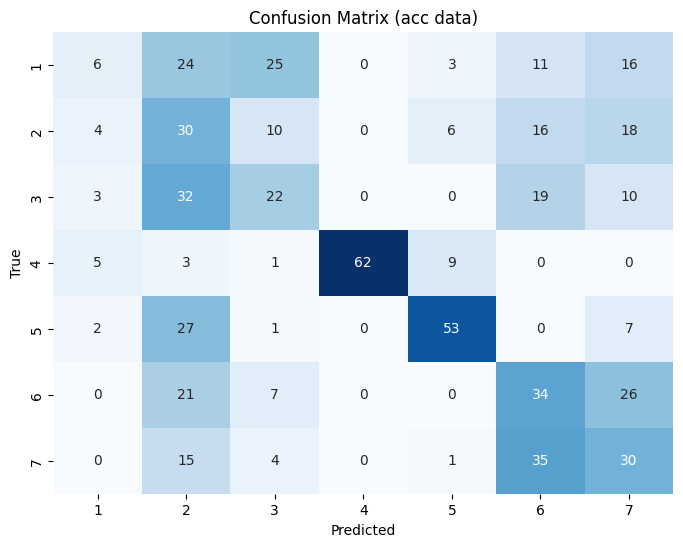


F1 scores for each class: [0.3125     0.33497537 0.87323944 0.65432099 0.11428571 0.25423729
 0.28205128]

F1 Macro Score: 0.4037


In [ ]:
# Apply PCA and LDA
df_train_transformed, df_test_transformed = reduce_dimensionality(
    df_train_standardized, df_test_standardized
)

# --- Verification ---
# Verify the shape of the transformed data
sample_window_train = df_train_transformed[df_train_transformed["sensor"] == "acc"].iloc[0]["df"]
sample_window_test = df_test_transformed[df_test_transformed["sensor"] == "acc"].iloc[0]["df"]

print(f"Transformed training data shape: {sample_window_train.shape}")
print(f"Transformed testing data shape: {sample_window_test.shape}")

# Verify the number of windows in each set (should be unchanged)
print(f"Training set size: {len(df_train_transformed)/2}")
print(f"Testing set size: {len(df_test_transformed)/2}")

# Perform fusion and classification
y_true, y_pred, label_mapping = fuse_and_classify(df_train_transformed, df_test_transformed)  # Receive label_mapping

# Convert y_true to numerical labels using label_mapping
y_true_numeric = np.array([label_mapping[label] for label in y_true])

# --- Evaluate performance ---

# Convert numerical labels back to string labels for evaluation
# Create reverse mapping
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_pred_strings = [reverse_label_mapping[label] for label in y_pred]

# Evaluate performance
cm = confusion_matrix(y_true, y_pred_strings)

# Plot confusion matrix using seaborn with labels from 1 to 7
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=range(1, 8),  # Labels from 1 to 7
            yticklabels=range(1, 8))  # Labels from 1 to 7
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (acc data)")
plt.show()

# Calculate F1 scores for each class (use y_true_numeric and y_pred)
f1_scores = f1_score(y_true_numeric, y_pred, average=None)

# Calculate macro F1 score
f1_macro = np.mean(f1_scores)

# Print F1 scores
print("\n" + "="*50)
print("F1 scores for each class:", f1_scores)
print("="*50)
print(f"\nF1 Macro Score: \033[1;32m{f1_macro:.4f}\033[0m")
print("="*50)

<a id='task2'></a>
<div class=" alert alert-warning">
<p> <b>2.2</b>

## Dimensionality Reduction for Depth Images

In this section, we will apply **Principal Component Analysis (PCA)** and **Linear Discriminant Analysis (LDA)** to reduce the dimensionality of **depth image data** while ensuring proper standardization. The processed features will then be used in a **Nearest Neighbor (NN) classification model**, and the results will be evaluated on the **test dataset**.

### **Steps for Processing Depth Image Data**
Each depth image is originally represented as a **12 × 16 matrix**, which is reshaped into a **192-dimensional vector** for processing. Before applying PCA and LDA, the data will be **standardized** to have **zero mean and unit variance** along each axis.

Using the **training dataset**, we will:

- **Fit PCA** with a **5-dimensional subspace**, selecting the **five largest principal components**.  
- **Fit LDA** with a **5-dimensional subspace**.  
- **Transform both training and testing examples** into this **low-dimensional feature representation**.  
- **Concatenate each sequence** into a single vector of size **5 × 1 × (5 + 5)**.  
- **Perform PCA and LDA fusion** in a similar manner to **Task 2.1**, utilizing the **Nearest Neighbor (NN) classifier** for classification.  
- **Evaluate the model performance** on the test set.  
    
</div>

Moving data to GPU...
Data moved to GPU in 0.3354 seconds
Calculating distances for test example 1/598...
Distances calculated in 0.4854 seconds
Normalizing and fusing distances...
Normalization and fusion done in 0.7671 seconds
--------------------
Calculating distances for test example 2/598...
Distances calculated in 0.4589 seconds
Normalizing and fusing distances...
Normalization and fusion done in 0.7616 seconds
--------------------
Calculating distances for test example 3/598...
Distances calculated in 0.4794 seconds
Normalizing and fusing distances...
Normalization and fusion done in 0.7529 seconds
--------------------
Calculating distances for test example 4/598...
Distances calculated in 0.4894 seconds
Normalizing and fusing distances...
Normalization and fusion done in 0.7813 seconds
--------------------
Calculating distances for test example 5/598...
Distances calculated in 0.4742 seconds
Normalizing and fusing distances...
Normalization and fusion done in 0.7664 seconds
---

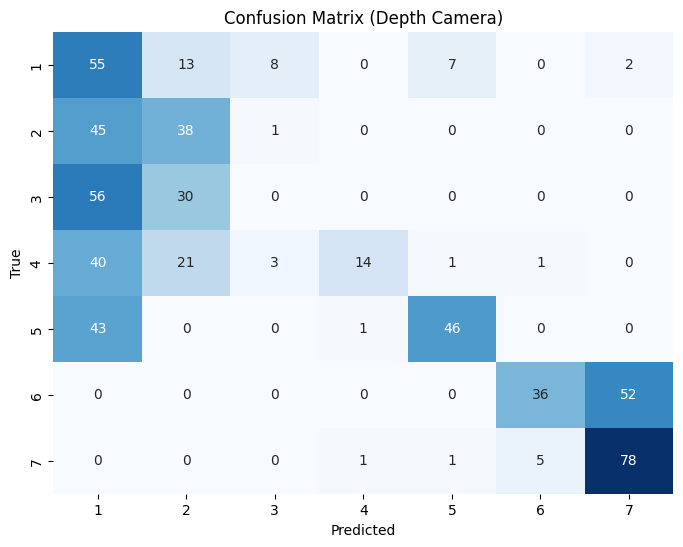


F1 scores for each class (Depth Camera): [0.71889401 0.55384615 0.29166667 0.63448276 0.33950617 0.40860215
 0.        ]

F1 Macro Score (Depth Camera): 0.4210


In [ ]:
# 2.2

# --- Standardization ---
def standardize_data_dc(df_train, df_test):
    """Standardizes depth camera data to zero mean and unit variance.

    Applies standardization along each axis of the flattened image data
    within the nested 'df' DataFrames for depth camera sensor data.

    Args:
        df_train: The training DataFrame.
        df_test: The testing DataFrame.

    Returns:
        A tuple containing the standardized training DataFrame and the standardized
        testing DataFrame.
    """

    df_train_standardized = df_train.copy()
    df_test_standardized = df_test.copy()

    # Fit standardization parameters on the training data
    train_dc_data = []
    for index, row in df_train_standardized.iterrows():
        if row["sensor"] == "dc":
            # Flatten each frame and concatenate frames within the window
            flattened_frames = []
            for i in range(0, row["df"].shape[0]):
                flattened_frames.append(
                    row["df"].iloc[i, 1:].to_numpy().flatten()
                )  # to_numpy before flatten
            train_dc_data.append(np.concatenate(flattened_frames))

    train_dc_data = np.array(train_dc_data)

    # Reshape train_dc_data to have each frame as a separate row
    train_dc_data_reshaped = train_dc_data.reshape(-1, 192)

    mean = np.mean(train_dc_data_reshaped, axis=0)
    std = np.std(train_dc_data_reshaped, axis=0)

    # Apply standardization to training data
    for index, row in df_train_standardized.iterrows():
        if row["sensor"] == "dc":
            df_dc = row["df"].copy()

            # Standardize each frame individually
            standardized_frames = []
            for i in range(0, df_dc.shape[0]):
                standardized_frame = (df_dc.iloc[i, 1:].to_numpy() - mean) / std
                standardized_frames.append(standardized_frame)

            # Update the DataFrame with standardized frames
            for i, frame in enumerate(standardized_frames):
                df_dc.iloc[i, 1:] = frame

            df_train_standardized.at[index, "df"] = df_dc

    # Apply standardization to testing data using training data parameters
    for index, row in df_test_standardized.iterrows():
        if row["sensor"] == "dc":
            df_dc = row["df"].copy()

            # Standardize each frame individually
            standardized_frames = []
            for i in range(0, df_dc.shape[0]):
                standardized_frame = (df_dc.iloc[i, 1:].to_numpy() - mean) / std
                standardized_frames.append(standardized_frame)

            # Update the DataFrame with standardized frames
            for i, frame in enumerate(standardized_frames):
                df_dc.iloc[i, 1:] = frame

            df_test_standardized.at[index, "df"] = df_dc

    return df_train_standardized, df_test_standardized

# --- Dimensionality Reduction using PCA and LDA (for Depth Camera) ---
def reduce_dimensionality_dc(df_train, df_test, n_components_pca=5, n_components_lda=5):
    """
    Reduces the dimensionality of depth camera data using PCA and LDA.

    Args:
        df_train: The standardized training DataFrame.
        df_test: The standardized testing DataFrame.
        n_components_pca: The number of principal components for PCA.
        n_components_lda: The number of components for LDA.

    Returns:
        A tuple containing the transformed training DataFrame and the transformed
        testing DataFrame, where each depth camera window is represented by a
        concatenated vector of PCA and LDA components.
    """

    # Prepare data for PCA and LDA
    X_train = []
    y_train = []
    for index, row in df_train.iterrows():
        if row["sensor"] == "dc":
            X_train.append(
                np.concatenate([row["df"].iloc[i][1:].values.flatten() for i in range(len(row["df"]))])
            )  # Flatten each image to a 1D array
            y_train.append(row["exercise_id"])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = []
    for index, row in df_test.iterrows():
        if row["sensor"] == "dc":
            X_test.append(np.concatenate([row["df"].iloc[i][1:].values.flatten() for i in range(len(row["df"]))]))
    X_test = np.array(X_test)

    # --- PCA ---
    pca = PCA(n_components=n_components_pca)
    pca.fit(X_train)  # Fit PCA on training data

    # Transform both training and testing data
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # --- LDA ---
    lda = LDA(n_components=n_components_lda)
    lda.fit(X_train, y_train)  # Fit LDA on training data

    # Transform both training and testing data
    X_train_lda = lda.transform(X_train)
    X_test_lda = lda.transform(X_test)

    # --- Concatenate PCA and LDA components ---
    X_train_combined = np.concatenate((X_train_pca, X_train_lda), axis=1)
    X_test_combined = np.concatenate((X_test_pca, X_test_lda), axis=1)

    # --- Update DataFrames ---
    df_train_transformed = df_train.copy()
    df_test_transformed = df_test.copy()

    train_idx = 0
    for index, row in df_train_transformed.iterrows():
        if row["sensor"] == "dc":
            df_train_transformed.at[index, "df"] = X_train_combined[train_idx, :]
            train_idx += 1

    test_idx = 0
    for index, row in df_test_transformed.iterrows():
        if row["sensor"] == "dc":
            df_test_transformed.at[index, "df"] = X_test_combined[test_idx, :]
            test_idx += 1

    return df_train_transformed, df_test_transformed

# --- Fusion of PCA and LDA (for Depth Camera) ---
def fuse_and_classify_dc(df_train_transformed, df_test_transformed):
    """
    Performs fusion of PCA and LDA representations and classifies test examples for depth camera data.

    Uses CuPy for GPU acceleration.

    Args:
        df_train_transformed: The transformed training DataFrame.
        df_test_transformed: The transformed testing DataFrame.

    Returns:
        A tuple containing:
            - y_true: True labels of the test set (as a NumPy array).
            - y_pred: Predicted labels for the test set (as a NumPy array).
            - label_mapping: Dictionary mapping exercise_id to numerical labels.
    """

    y_true = []
    y_pred = []

    # Create a mapping from exercise_id to a unique integer label
    label_mapping = {
        label: i for i, label in enumerate(df_train_transformed["exercise_id"].unique())
    }

    # Move data to GPU
    print("Moving data to GPU...")
    start_time = time.time()
    df_train_gpu = df_train_transformed.copy()
    df_test_gpu = df_test_transformed.copy()

    for index, row in df_train_gpu.iterrows():
        if row["sensor"] == "dc":
            df_train_gpu.at[index, "df"] = cp.asarray(row["df"])

    for index, row in df_test_gpu.iterrows():
        if row["sensor"] == "dc":
            df_test_gpu.at[index, "df"] = cp.asarray(row["df"])
    print(f"Data moved to GPU in {time.time() - start_time:.4f} seconds")

    total_test_examples = len(df_test_gpu[df_test_gpu["sensor"] == "dc"])
    for test_index, test_row in df_test_gpu.iterrows():
        if test_row["sensor"] == "dc":
            test_data = test_row["df"]
            y_true.append(test_row["exercise_id"])

            min_dist = float("inf")
            predicted_label = None

            # Calculate distances on GPU
            print(
                f"Calculating distances for test example {len(y_pred) + 1}/{total_test_examples}..."
            )
            start_time = time.time()

            pca_distances = []
            lda_distances = []
            for train_index, train_row in df_train_gpu.iterrows():
                if train_row["sensor"] == "dc":
                    train_data = train_row["df"]

                    pca_dist = cp.sum((test_data[:5] - train_data[:5]) ** 2)
                    lda_dist = cp.sum((test_data[5:] - train_data[5:]) ** 2)

                    pca_distances.append(pca_dist)
                    lda_distances.append(lda_dist)

            # Find min and max distances on GPU
            pca_distances = cp.array(pca_distances)
            lda_distances = cp.array(lda_distances)

            min_pca_dist = cp.min(pca_distances)
            max_pca_dist = cp.max(pca_distances)
            min_lda_dist = cp.min(lda_distances)
            max_lda_dist = cp.max(lda_distances)

            end_time = time.time()
            print(f"Distances calculated in {end_time - start_time:.4f} seconds")

            # Normalize and fuse distances on GPU
            print("Normalizing and fusing distances...")
            start_time = time.time()

            for train_index, train_row in df_train_gpu.iterrows():
                if train_row["sensor"] == "dc":
                    train_data = train_row["df"]

                    pca_dist = cp.sum((test_data[:5] - train_data[:5]) ** 2)
                    lda_dist = cp.sum((test_data[5:] - train_data[5:]) ** 2)

                    pca_dist_norm = (pca_dist - min_pca_dist) / (
                        max_pca_dist - min_pca_dist
                    )
                    lda_dist_norm = (lda_dist - min_lda_dist) / (
                        max_lda_dist - min_lda_dist
                    )
                    fused_dist = (pca_dist_norm + lda_dist_norm) / 2

                    # Update nearest neighbor
                    if fused_dist < min_dist:
                        min_dist = fused_dist
                        predicted_label = train_row["exercise_id"]

            # Convert predicted label to numerical label using the mapping
            predicted_label_numeric = label_mapping[predicted_label]
            y_pred.append(predicted_label_numeric)

            end_time = time.time()
            print(f"Normalization and fusion done in {end_time - start_time:.4f} seconds")
            print("-" * 20)

    return np.array(y_true), cp.asnumpy(cp.array(y_pred)), label_mapping

"""
    MAIN CODE
"""

# --- Main Execution (for Depth Camera) ---

# Apply standardization (for depth camera data)
df_train_standardized_dc, df_test_standardized_dc = standardize_data_dc(df_train, df_test)

# Apply PCA and LDA (for depth camera data)
df_train_transformed_dc, df_test_transformed_dc = reduce_dimensionality_dc(
    df_train_standardized_dc, df_test_standardized_dc
)

# Perform fusion and classification (for depth camera data)
y_true_dc, y_pred_dc, label_mapping_dc = fuse_and_classify_dc(
    df_train_transformed_dc, df_test_transformed_dc
)

# Convert numerical labels back to string labels for evaluation
reverse_label_mapping_dc = {v: k for k, v in label_mapping_dc.items()}
y_pred_strings_dc = [reverse_label_mapping_dc[label] for label in y_pred_dc]

# --- Evaluate performance (for Depth Camera) ---

# Calculate confusion matrix
cm_dc = confusion_matrix(y_true_dc, y_pred_strings_dc)

# Plot confusion matrix using seaborn with correct labels (1-7)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dc, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=range(1, 8),  # Labels from 1 to 7 for predicted
            yticklabels=range(1, 8))  # Labels from 1 to 7 for actual
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Depth Camera)")
plt.show()

# Convert y_true_dc to numerical labels using label_mapping_dc
y_true_numeric_dc = np.array([label_mapping_dc[label] for label in y_true_dc])

# Calculate F1 scores for each class
f1_scores_dc = f1_score(y_true_numeric_dc, y_pred_dc, average=None)

# Calculate macro F1 score
f1_macro_dc = np.mean(f1_scores_dc)

# Print F1 scores
print("\n" + "="*50)
print("F1 scores for each class (Depth Camera):", f1_scores_dc)
print("="*50)
print(f"\nF1 Macro Score (Depth Camera): \033[1;32m{f1_macro_dc:.4f}\033[0m")
print("="*50)

# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='part3'></a>
<div class=" alert alert-warning">
    <b>Part 3.</b>

## Feature Extraction and Classifier Comparison

In this section, we will prepare new feature sets for each modality and combine them into a **single feature representation**. Two different classifiers from **scikit-learn** will be trained using this **joint feature representation**, and their performance will be evaluated and compared using the **testing dataset**.

### **3.1 Feature Extraction for Accelerometer Data**

Following a similar approach as in **Part 2.1**, we will apply **Principal Component Analysis (PCA)** to extract the most significant features from accelerometer data. However, instead of selecting five components, we will now choose the **10 largest principal components**, resulting in a **10-dimensional feature vector** for each window.

Additionally, we will compute **statistical features** for each window:
- **Mean** and **standard deviation** for each of the three accelerometer channels (X, Y, and Z).
- This results in a **6-dimensional vector** (3 means + 3 standard deviations).

Finally, we will combine the **PCA-based features** and the **statistical features** into a **36-dimensional feature vector** for each window.

### **Documentation and Analysis**
The extracted features will be documented, and their effectiveness in classification will be analyzed. The next steps will involve training and comparing classifiers using the newly created feature representation.

    
</div>

In [ ]:
# 3.1

# --- Dimensionality Reduction using PCA and Statistical Features (Accelerometer) ---

def reduce_dimensionality_acc(df_train, df_test, n_components_pca=10):
    """
    Reduces the dimensionality of accelerometer data using PCA and
    calculates statistical features (mean and standard deviation).

    Applies PCA separately to each accelerometer channel.

    Args:
        df_train: The standardized training DataFrame.
        df_test: The standardized testing DataFrame.
        n_components_pca: The number of principal components for PCA.

    Returns:
        A tuple containing the transformed training DataFrame and the transformed
        testing DataFrame, where each accelerometer window is represented by a
        concatenated vector of PCA components and statistical features.
    """

    # Prepare data for PCA
    X_train = []
    for index, row in df_train.iterrows():
        if row["sensor"] == "acc":
            X_train.append(row["df"][["acc_0", "acc_1", "acc_2"]].values)
    X_train = np.array(X_train)

    X_test = []
    for index, row in df_test.iterrows():
        if row["sensor"] == "acc":
            X_test.append(row["df"][["acc_0", "acc_1", "acc_2"]].values)
    X_test = np.array(X_test)

    # --- PCA ---
    # Apply PCA separately to each channel
    X_train_pca = []
    X_test_pca = []

    for i in range(3):  # 3 accelerometer channels
        pca = PCA(n_components=n_components_pca)
        X_train_channel = X_train[:, :, i]  # Select data for the current channel
        X_test_channel = X_test[:, :, i]
        pca.fit(X_train_channel)  # Fit PCA on training data

        # Transform both training and testing data
        X_train_pca_channel = pca.transform(X_train_channel)
        X_test_pca_channel = pca.transform(X_test_channel)
        X_train_pca.append(X_train_pca_channel)
        X_test_pca.append(X_test_pca_channel)

    # Concatenate PCA components from all channels
    X_train_pca = np.concatenate(X_train_pca, axis=1)
    X_test_pca = np.concatenate(X_test_pca, axis=1)

    # --- Statistical Features ---
    X_train_stats = []
    for index, row in df_train.iterrows():
        if row["sensor"] == "acc":
            # Calculate mean and std for each channel
            means = row["df"][["acc_0", "acc_1", "acc_2"]].mean().values
            stds = row["df"][["acc_0", "acc_1", "acc_2"]].std().values
            X_train_stats.append(np.concatenate((means, stds)))
    X_train_stats = np.array(X_train_stats)

    X_test_stats = []
    for index, row in df_test.iterrows():
        if row["sensor"] == "acc":
            # Calculate mean and std for each channel
            means = row["df"][["acc_0", "acc_1", "acc_2"]].mean().values
            stds = row["df"][["acc_0", "acc_1", "acc_2"]].std().values
            X_test_stats.append(np.concatenate((means, stds)))
    X_test_stats = np.array(X_test_stats)

    # --- Concatenate PCA and Statistical Features ---
    X_train_combined = np.concatenate((X_train_pca, X_train_stats), axis=1)
    X_test_combined = np.concatenate((X_test_pca, X_test_stats), axis=1)

    # --- Update DataFrames ---
    df_train_transformed = df_train.copy()
    df_test_transformed = df_test.copy()

    train_idx = 0
    for index, row in df_train_transformed.iterrows():
        if row["sensor"] == "acc":
            df_train_transformed.at[index, "df"] = X_train_combined[train_idx, :]
            train_idx += 1

    test_idx = 0
    for index, row in df_test_transformed.iterrows():
        if row["sensor"] == "acc":
            df_test_transformed.at[index, "df"] = X_test_combined[test_idx, :]
            test_idx += 1

    return df_train_transformed, df_test_transformed

"""
    MAIN CODE
"""

# --- Main Execution (for Accelerometer) ---
# Apply PCA and calculate statistical features
df_train_transformed_acc, df_test_transformed_acc = reduce_dimensionality_acc(
    df_train_standardized, df_test_standardized
)

# --- Verification (for Accelerometer) ---
sample_window_train_acc = df_train_transformed_acc[df_train_transformed_acc["sensor"] == "acc"].iloc[0]["df"]
sample_window_test_acc = df_test_transformed_acc[df_test_transformed_acc["sensor"] == "acc"].iloc[0]["df"]

print(f"Transformed training data shape (Accelerometer): {sample_window_train_acc.shape}")
print(f"Transformed testing data shape (Accelerometer): {sample_window_test_acc.shape}")

# Verify the number of windows in each set (should be unchanged)
print(f"Training set size (Accelerometer): {len(df_train_transformed_acc)/2}")
print(f"Testing set size (Accelerometer): {len(df_test_transformed_acc)/2}")
### Your code ends here ###

# Save df_records to a CSV file
df_train_transformed_acc.to_csv("df_train_transformed_acc.csv", index=False)

Transformed training data shape (Accelerometer): (36,)
Transformed testing data shape (Accelerometer): (36,)
Training set size (Accelerometer): 1486.0
Testing set size (Accelerometer): 598.0


<a id='part3'></a>
<div class=" alert alert-warning">

### **3.2 Feature Extraction for Depth Images**

Following a similar approach as in **Part 2.2**, we will apply **Principal Component Analysis (PCA)** to extract the most significant features from depth image data. Using the same setup, we will now select the **10 largest principal components** to form the feature vector for each depth image.

Since each windowed example contains a sequence of **5 frames**, we will concatenate the extracted **PCA components** from all frames, resulting in a **50-dimensional feature vector** for each window.

    
</div>

In [ ]:
# 3.2

# --- Dimensionality Reduction using PCA (Depth Camera) ---

def reduce_dimensionality_dc_pca(df_train, df_test, n_components_pca=10):
    """
    Reduces the dimensionality of depth camera data using PCA.

    Args:
        df_train: The standardized training DataFrame.
        df_test: The standardized testing DataFrame.
        n_components_pca: The number of principal components for PCA.

    Returns:
        A tuple containing the transformed training DataFrame and the transformed
        testing DataFrame, where each depth camera window is represented by a
        vector of PCA components.
    """

    # Prepare data for PCA
    X_train = []
    for index, row in df_train.iterrows():
        if row["sensor"] == "dc":
            # Process each frame separately
            X_train.append(
                np.array(
                    [
                        row["df"].iloc[i, 1:].to_numpy().flatten()
                        for i in range(0, row["df"].shape[0])
                    ]
                )
            )  # to_numpy before flatten
    X_train = np.array(X_train)

    X_test = []
    for index, row in df_test.iterrows():
        if row["sensor"] == "dc":
            # Process each frame separately
            X_test.append(
                np.array(
                    [
                        row["df"].iloc[i, 1:].to_numpy().flatten()
                        for i in range(0, row["df"].shape[0])
                    ]
                )
            )
    X_test = np.array(X_test)

    # --- PCA ---
    # Apply PCA separately to each frame
    X_train_pca = []
    X_test_pca = []

    for i in range(5):  # 5 frames
        pca = PCA(n_components=n_components_pca)
        X_train_frame = X_train[:, i, :]
        X_test_frame = X_test[:, i, :]
        pca.fit(X_train_frame)  # Fit PCA on training data

        # Transform both training and testing data
        X_train_pca_frame = pca.transform(X_train_frame)
        X_test_pca_frame = pca.transform(X_test_frame)
        X_train_pca.append(X_train_pca_frame)
        X_test_pca.append(X_test_pca_frame)

    # Concatenate PCA components from all frames
    X_train_combined = np.concatenate(X_train_pca, axis=1)
    X_test_combined = np.concatenate(X_test_pca, axis=1)

    # --- Update DataFrames ---
    df_train_transformed = df_train.copy()
    df_test_transformed = df_test.copy()

    train_idx = 0
    for index, row in df_train_transformed.iterrows():
        if row["sensor"] == "dc":
            df_train_transformed.at[index, "df"] = X_train_combined[train_idx, :]
            train_idx += 1

    test_idx = 0
    for index, row in df_test_transformed.iterrows():
        if row["sensor"] == "dc":
            df_test_transformed.at[index, "df"] = X_test_combined[test_idx, :]
            test_idx += 1

    return df_train_transformed, df_test_transformed

"""
    MAIN CODE
"""

# --- Main Execution (for Depth Camera) ---

# Apply PCA (for depth camera data)
df_train_transformed_dc, df_test_transformed_dc = reduce_dimensionality_dc_pca(
    df_train_standardized_dc, df_test_standardized_dc
)

# --- Verification (for Depth Camera) ---
sample_window_train_dc = df_train_transformed_dc[df_train_transformed_dc["sensor"] == "dc"].iloc[0]["df"]
sample_window_test_dc = df_test_transformed_dc[df_test_transformed_dc["sensor"] == "dc"].iloc[0]["df"]

print(f"Transformed training data shape (Depth Camera): {sample_window_train_dc.shape}")
print(f"Transformed testing data shape (Depth Camera): {sample_window_test_dc.shape}")

# Verify the number of windows in each set (should be unchanged)
print(f"Training set size (Depth Camera): {len(df_train_transformed_dc)/2}")
print(f"Testing set size (Depth Camera): {len(df_test_transformed_dc)/2}")

# Save df_records to a CSV file
df_train_transformed_dc.to_csv("df_train_transformed_dc.csv", index=False)

Transformed training data shape (Depth Camera): (50,)
Transformed testing data shape (Depth Camera): (50,)
Training set size (Depth Camera): 1486.0
Testing set size (Depth Camera): 598.0


<a id='part3'></a>
<div class=" alert alert-warning">

### **3.3 Joint Feature Representation and Classifier Evaluation**

In this section, we will combine the extracted features from **Part 3.1 (Accelerometer)** and **Part 3.2 (Depth Images)** to form a **joint feature representation**. This results in an **86-dimensional feature vector** for each example, comprising:  

- **36 features** from accelerometer data (PCA components + statistical features).  
- **50 features** from depth image data (concatenated PCA components).  

#### **Data Normalization**  
To ensure consistency across different feature scales, we will **normalize the data** to the range **[0,1]** using the **training dataset**. Normalization will be performed **along each axis** before training the classifiers.

#### **Classification and Evaluation**  
Two different classifiers from **scikit-learn** will be used for classification:  

- **Support Vector Machine (SVM)** with **RBF kernel**  
- **Gaussian Naïve Bayes (NB)** (default parameter values)  

The classifiers will be **trained** using the joint feature representation and then **evaluated** on the test dataset. The performance of each model will be assessed using:  

- **Confusion matrices**  
- **F1 scores**  
    
</div>

In [ ]:
# 3.3 Combine Features and Normalize

def combine_and_normalize_features(df_train_acc, df_test_acc, df_train_dc, df_test_dc):
    """
    Combines the accelerometer and depth camera feature vectors into a single DataFrame.
    Handles missing data by skipping windows without any data.
    Normalizes the combined features to the range [0, 1] using the training data.

    Args:
        df_train_acc: DataFrame with accelerometer features for training.
        df_test_acc: DataFrame with accelerometer features for testing.
        df_train_dc: DataFrame with depth camera features for training.
        df_test_dc: DataFrame with depth camera features for testing.

    Returns:
        A tuple containing:
            - df_train_combined_normalized: DataFrame with combined and normalized features for training.
            - df_test_combined_normalized: DataFrame with combined and normalized features for testing.
    """

    df_train_combined = []
    df_test_combined = []

    # Combine features for training set
    for index_acc, row_acc in df_train_acc.iterrows():
        if row_acc["sensor"] == "acc":
            # Find the corresponding depth camera window in the training set
            matching_dc_row = df_train_dc[
                (df_train_dc["sensor"] == "dc")
                & (df_train_dc["subject_id"] == row_acc["subject_id"])
                & (df_train_dc["exercise_id"] == row_acc["exercise_id"])
                & (df_train_dc["window_idx"] == row_acc["window_idx"])
            ]

            # Check if accelerometer data exists for this window in the training set
            matching_acc_row = df_train_acc[
                (df_train_acc["sensor"] == "acc")
                & (df_train_acc["subject_id"] == row_acc["subject_id"])
                & (df_train_acc["exercise_id"] == row_acc["exercise_id"])
                & (df_train_acc["window_idx"] == row_acc["window_idx"])
            ]

            if not matching_dc_row.empty and not matching_acc_row.empty:
                # Both accelerometer and depth camera data found
                dc_data = matching_dc_row.iloc[0]["df"]
                combined_features = np.concatenate((row_acc["df"], dc_data))

                new_row = row_acc.copy()
                new_row["df"] = combined_features
                new_row["sensor"] = "combined"
                df_train_combined.append(new_row)

            elif matching_acc_row.empty and matching_dc_row.empty:
                # Neither accelerometer nor depth camera data found
                print(
                    f"Warning: No accelerometer or depth camera data found for: "
                    f"Subject {row_acc['subject_id']}, Exercise {row_acc['exercise_id']}, Window {row_acc['window_idx']} (Training)"
                )
                continue  # Skip this window
            elif not matching_acc_row.empty:
                # Accelerometer data found, but no depth camera
                print(
                    f"Warning: No matching depth camera window found for accelerometer window: "
                    f"Subject {row_acc['subject_id']}, Exercise {row_acc['exercise_id']}, Window {row_acc['window_idx']} (Training)"
                )
                # Pad with zeros for depth camera features
                dc_data = np.zeros(50)  # 50 is the dimensionality of depth camera features
                combined_features = np.concatenate((row_acc["df"], dc_data))

                new_row = row_acc.copy()
                new_row["df"] = combined_features
                new_row["sensor"] = "combined"
                df_train_combined.append(new_row)

    # Combine features for testing set
    for index_acc, row_acc in df_test_acc.iterrows():
        if row_acc["sensor"] == "acc":
            # Find the corresponding depth camera window in the testing set
            matching_dc_row = df_test_dc[
                (df_test_dc["sensor"] == "dc")
                & (df_test_dc["subject_id"] == row_acc["subject_id"])
                & (df_test_dc["exercise_id"] == row_acc["exercise_id"])
                & (df_test_dc["window_idx"] == row_acc["window_idx"])
            ]

            # Check if accelerometer data exists for this window in the testing set
            matching_acc_row = df_test_acc[
                (df_test_acc["sensor"] == "acc")
                & (df_test_acc["subject_id"] == row_acc["subject_id"])
                & (df_test_acc["exercise_id"] == row_acc["exercise_id"])
                & (df_test_acc["window_idx"] == row_acc["window_idx"])
            ]

            if not matching_dc_row.empty and not matching_acc_row.empty:
                # Both accelerometer and depth camera data found
                dc_data = matching_dc_row.iloc[0]["df"]
                combined_features = np.concatenate((row_acc["df"], dc_data))

                new_row = row_acc.copy()
                new_row["df"] = combined_features
                new_row["sensor"] = "combined"
                df_test_combined.append(new_row)

            elif matching_acc_row.empty and matching_dc_row.empty:
                # Neither accelerometer nor depth camera data found
                print(
                    f"Warning: No accelerometer or depth camera data found for: "
                    f"Subject {row_acc['subject_id']}, Exercise {row_acc['exercise_id']}, Window {row_acc['window_idx']} (Testing)"
                )
                continue  # Skip this window
            elif not matching_acc_row.empty:
                # Accelerometer data found, but no depth camera
                print(
                    f"Warning: No matching depth camera window found for accelerometer window: "
                    f"Subject {row_acc['subject_id']}, Exercise {row_acc['exercise_id']}, Window {row_acc['window_idx']} (Testing)"
                )
                # Pad with zeros for depth camera features
                dc_data = np.zeros(50)  # 50 is the dimensionality of depth camera features
                combined_features = np.concatenate((row_acc["df"], dc_data))

                new_row = row_acc.copy()
                new_row["df"] = combined_features
                new_row["sensor"] = "combined"
                df_test_combined.append(new_row)

    df_train_combined = pd.DataFrame(df_train_combined)
    df_test_combined = pd.DataFrame(df_test_combined)

    # Normalize combined features using MinMaxScaler
    X_train = np.array(df_train_combined["df"].tolist())
    X_test = np.array(df_test_combined["df"].tolist())

    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    # Update combined DataFrames with normalized features
    train_idx = 0
    for index, row in df_train_combined.iterrows():
        df_train_combined.at[index, "df"] = X_train_normalized[train_idx, :]
        train_idx += 1

    test_idx = 0
    for index, row in df_test_combined.iterrows():
        df_test_combined.at[index, "df"] = X_test_normalized[test_idx, :]
        test_idx += 1

    return df_train_combined, df_test_combined

"""
    MAIN CODE
"""

# --- Main Execution ---

# Combine and normalize features
df_train_combined_normalized, df_test_combined_normalized = combine_and_normalize_features(
    df_train_transformed_acc, df_test_transformed_acc, df_train_transformed_dc, df_test_transformed_dc
)

# --- Verification ---
sample_window_train_combined = df_train_combined_normalized[df_train_combined_normalized["sensor"] == "combined"].iloc[0]["df"]
sample_window_test_combined = df_test_combined_normalized[df_test_combined_normalized["sensor"] == "combined"].iloc[0]["df"]

print(f"Transformed training data shape (Combined): {sample_window_train_combined.shape}")
print(f"Transformed testing data shape (Combined): {sample_window_test_combined.shape}")

# Verify the number of windows in each set
print(f"Training set size (Combined): {len(df_train_combined_normalized)}")
print(f"Testing set size (Combined): {len(df_test_combined_normalized)}")

# Check the range of the normalized data (should be between 0 and 1)
print(f"Min value in training data (Combined): {np.min(sample_window_train_combined):.4f}")
print(f"Max value in training data (Combined): {np.max(sample_window_train_combined):.4f}")

#display(df_train_transformed_acc.head())
#display(df_train_transformed_dc.head())

# Save df_records to a CSV file
#df_train_transformed_dc.to_csv("df_train_transformed_dc.csv", index=False)

Transformed training data shape (Combined): (86,)
Transformed testing data shape (Combined): (86,)
Training set size (Combined): 1486
Testing set size (Combined): 598
Min value in training data (Combined): 0.0171
Max value in training data (Combined): 0.8861



--- SVM with RBF Kernel ---
Confusion Matrix:
[[85  0  0  0  0  0  0]
 [ 1 64  0 11  0  0  8]
 [ 0 48 38  0  0  0  0]
 [15  0  0 65  0  0  0]
 [20  0  0  0 70  0  0]
 [ 0  0  0  0  0 17 71]
 [ 0  0  0  0  0  0 85]]

F1 Score (SVM): 0.6866


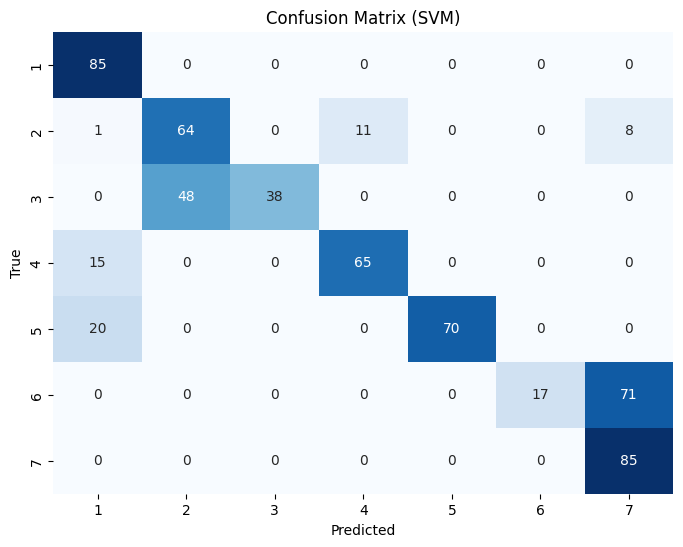


--- Gaussian Naive Bayes ---
Confusion Matrix:
[[85  0  0  0  0  0  0]
 [55  7  0  0  0  0 22]
 [ 9  2 54  0  0 21  0]
 [41  0  0 39  0  0  0]
 [19  0  0  0 46  0 25]
 [ 0  0  0  0  0 88  0]
 [ 0  0  0  0  0  0 85]]

F1 Score (Gaussian Naive Bayes): 0.6441


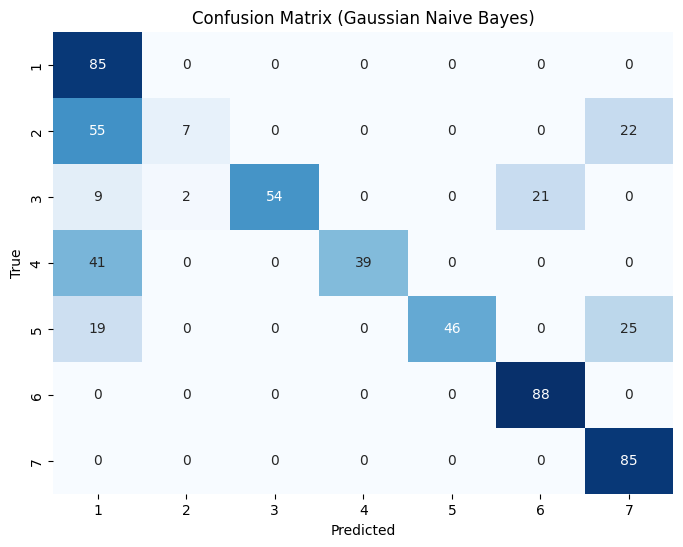


--- Analysis ---
SVM F1 Score: 0.6866
Gaussian Naive Bayes F1 Score: 0.6441

SVM performed better than Gaussian Naive Bayes.


In [ ]:
# --- Prepare Data for Classifiers ---

# Use df_train_combined_normalized and df_test_combined_normalized from the previous step (Task 3.3)

X_train = np.array(df_train_combined_normalized["df"].tolist())
y_train = df_train_combined_normalized["exercise_id"].values
X_test = np.array(df_test_combined_normalized["df"].tolist())
y_test = df_test_combined_normalized["exercise_id"].values

# Convert string labels to numerical labels
label_mapping = {label: i for i, label in enumerate(np.unique(y_train))}
y_train_numeric = np.array([label_mapping[label] for label in y_train])
y_test_numeric = np.array([label_mapping[label] for label in y_test])

"""
    Support Vector Machine (SVM) with RBF Kernel
"""

# --- Support Vector Machine (SVM) with RBF Kernel ---

# Create an SVM classifier with an RBF kernel
svm_classifier = SVC(kernel="rbf")  # Using default parameters

# Train the classifier
svm_classifier.fit(X_train, y_train_numeric)

# Predict on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate the SVM classifier
cm_svm = confusion_matrix(y_test_numeric, y_pred_svm)
f1_svm = f1_score(y_test_numeric, y_pred_svm, average="macro")

print("\n" + "="*50)
print("--- SVM with RBF Kernel ---")
print("Confusion Matrix:")
print(cm_svm)
print(f"\nF1 Score (SVM): \033[1;32m{f1_svm:.4f}\033[0m")
print("="*50)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())  # Use label_mapping for tick labels
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (SVM)")
plt.show()

"""
    Gaussian Naive Bayes Classifier
"""

# --- Gaussian Naive Bayes Classifier ---

# Create a Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()  # Using default parameters

# Train the classifier
gnb_classifier.fit(X_train, y_train_numeric)

# Predict on the test set
y_pred_gnb = gnb_classifier.predict(X_test)

# Evaluate the GNB classifier
cm_gnb = confusion_matrix(y_test_numeric, y_pred_gnb)
f1_gnb = f1_score(y_test_numeric, y_pred_gnb, average="macro")

print("\n" + "="*50)
print("--- Gaussian Naive Bayes ---")
print("Confusion Matrix:")
print(cm_gnb)
print(f"\nF1 Score (Gaussian Naive Bayes): \033[1;32m{f1_gnb:.4f}\033[0m")
print("="*50)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gnb, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())  # Use label_mapping for tick labels
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Gaussian Naive Bayes)")
plt.show()

# --- Analysis ---

print("\n" + "="*50)
print("--- Analysis ---")
print(f"\033[1;34mSVM F1 Score:\033[0m \033[1;32m{f1_svm:.4f}\033[0m")
print(f"\033[1;34mGaussian Naive Bayes F1 Score:\033[0m \033[1;32m{f1_gnb:.4f}\033[0m")
print("="*50)

if f1_svm > f1_gnb:
    print("\n\033[1;33mSVM performed better than Gaussian Naive Bayes.\033[0m")
elif f1_gnb > f1_svm:
    print("\n\033[1;33mGaussian Naive Bayes performed better than SVM.\033[0m")
else:
    print("\n\033[1;33mSVM and Gaussian Naive Bayes performed equally.\033[0m")

# 4. Decision-level fusion for multimodal classification

<a id='part4'></a>
<div class=" alert alert-warning">
    <b>Part 4.</b>

## **4. Decision-Level Fusion for Multimodal Classification**  

In this section, we will use the **features extracted in Part 3** for each modality and train separate **base classifiers** for accelerometer and depth image features. The classification outputs for each modality will then be **combined at the decision level** to improve classification performance. The trained models will be evaluated on the **test dataset**, and their results will be compared.

### **4.1 Base Classifiers and Parameter Optimization**  

For each modality, we will use the following **base classifiers** from **scikit-learn**:  

- **Support Vector Machine (SVM)** with an **RBF kernel**  
- **AdaBoost classifier** (with `random_state=0`)  

#### **Data Normalization**  
Before training, the data will be **normalized** to the range **[0,1]** using the **training dataset**. Normalization will be performed **along each axis** to maintain consistency across feature scales.

#### **Hyperparameter Tuning Using Grid Search**  
To optimize model performance, we will tune the classifiers' parameters using **10-fold cross-validation** on the training dataset. We will use **GridSearchCV** from **scikit-learn** to find the optimal set of parameters for each model:

- **SVM Parameters**:  
  - **C**: `[0.1, 1.0, 10.0, 100.0]`  
  - **gamma (RBF-kernel)**: `[0.1, 0.25, 0.5, 0.75, 1.0, 2.0]`  

- **AdaBoost Parameters**:  
  - **n_estimators**: `[50, 100, 500, 1000]`  
  - **learning_rate**: `[0.1, 0.25, 0.5, 0.75, 1.0]`  

Once the **best parameters** are selected, the classifiers will be **trained on the entire training dataset**.  

#### **Overfitting Considerations**  
Is there a possibility that the classifiers might **overfit** to the training data using this parameter selection strategy? If so, why? This question will be analyzed by comparing **training and testing performance** and examining the sensitivity of the models to hyperparameter choices.

### **Evaluation and Analysis**  
The performance of the trained classifiers will be evaluated on the **test dataset** using:  

- **Confusion matrices**  
- **F1 scores**  

    
</div>

Range of SVM (ACC) - Training Data: min=0.0, max=1.0
Range of SVM (ACC) - Test Data: min=-0.47679460975556615, max=1.427013942875528

--- SVM (ACC) ---
Best parameters: {'C': 100.0, 'gamma': 0.75}
Best F1 score (training): 0.9804

--- SVM (ACC) - Test Set ---
Confusion Matrix:
[[57  0  0  0  0  0 28]
 [ 0 42  0  0 13 29  0]
 [ 0 54  2  0  1 29  0]
 [ 6  0  0 73  1  0  0]
 [ 0 30  0  0 58  0  2]
 [ 0 23  0  0  0 65  0]
 [ 1  9  0  4  0  4 67]]
F1 Score (test): 0.5915


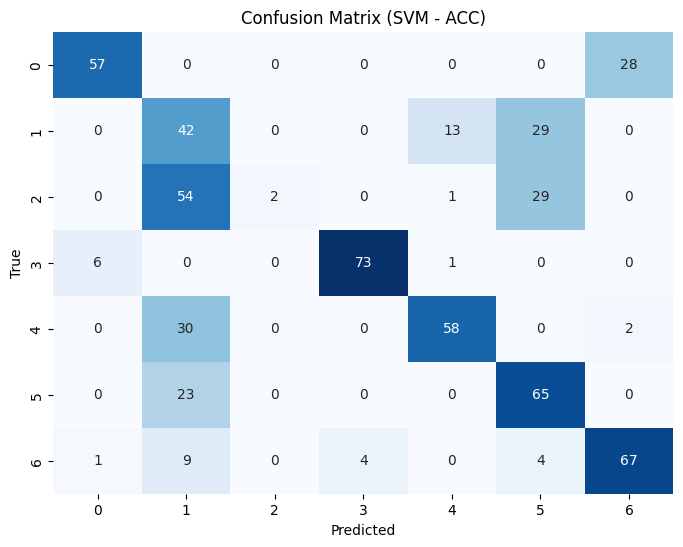

Range of AdaBoost (ACC) - Training Data: min=0.0, max=1.0
Range of AdaBoost (ACC) - Test Data: min=-0.47679460975556615, max=1.427013942875528

--- AdaBoost (ACC) ---
Best parameters: {'learning_rate': 1.0, 'n_estimators': 1000}
Best F1 score (training): 0.7985

--- AdaBoost (ACC) - Test Set ---
Confusion Matrix:
[[85  0  0  0  0  0  0]
 [10  5  0  0 25  8 36]
 [ 0 57  0  0  0 24  5]
 [14  0  0 45 21  0  0]
 [ 0  0  0  0 58  0 32]
 [ 0 27  0  0  0 57  4]
 [ 6  0  0  0  0  0 79]]
F1 Score (test): 0.5036


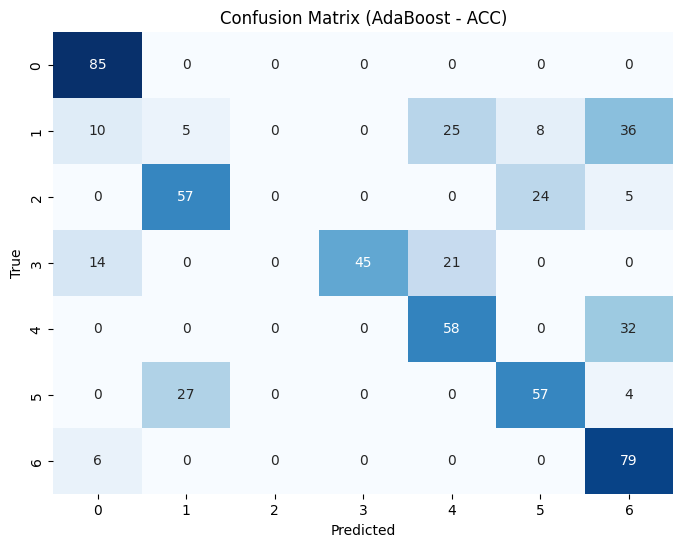

Range of SVM (DC) - Training Data: min=0.0, max=1.0
Range of SVM (DC) - Test Data: min=-0.5029645572819188, max=1.46289807121158

--- SVM (DC) ---
Best parameters: {'C': 10.0, 'gamma': 0.75}
Best F1 score (training): 0.9829

--- SVM (DC) - Test Set ---
Confusion Matrix:
[[78  0  0  0  0  0  7]
 [35 49  0  0  0  0  0]
 [80  1  5  0  0  0  0]
 [80  0  0  0  0  0  0]
 [73  0  0  8  9  0  0]
 [ 0  0  0  0  0 29 59]
 [ 0  0  0  0  0  0 85]]
F1 Score (test): 0.3716


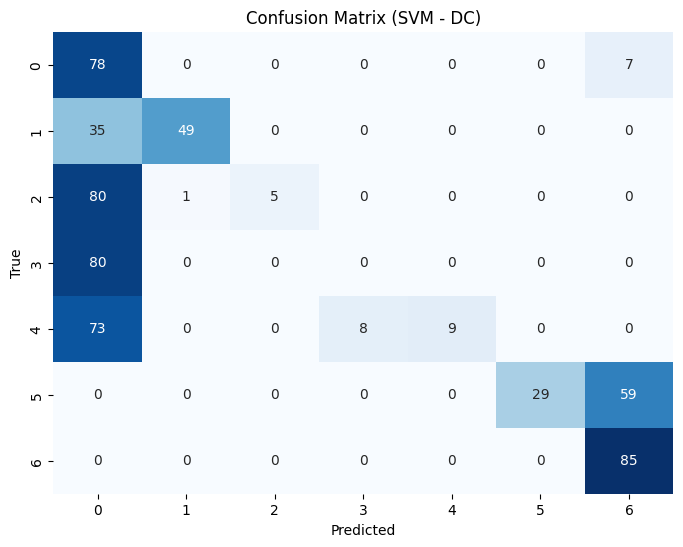

Range of AdaBoost (DC) - Training Data: min=0.0, max=1.0
Range of AdaBoost (DC) - Test Data: min=-0.5029645572819188, max=1.46289807121158

--- AdaBoost (DC) ---
Best parameters: {'learning_rate': 1.0, 'n_estimators': 1000}
Best F1 score (training): 0.5741

--- AdaBoost (DC) - Test Set ---
Confusion Matrix:
[[85  0  0  0  0  0  0]
 [80  4  0  0  0  0  0]
 [81  5  0  0  0  0  0]
 [70  1  0  9  0  0  0]
 [68  0  0  1 12  9  0]
 [ 3  2  0  0  0 73 10]
 [ 0  1  0  0  0 74 10]]
F1 Score (test): 0.2381


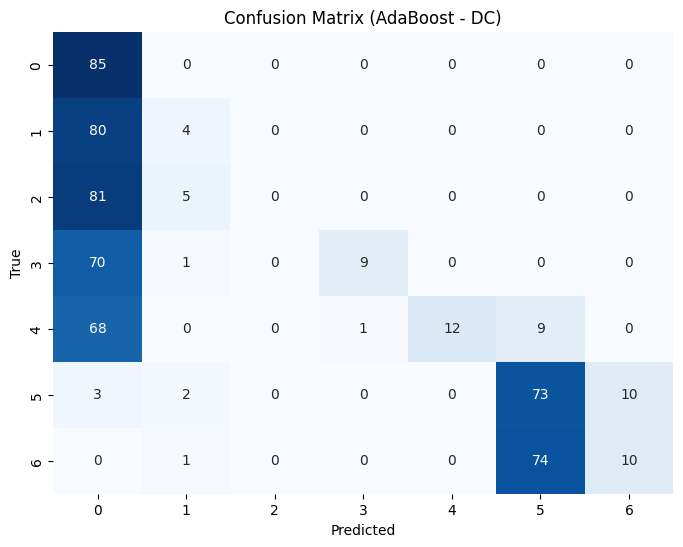

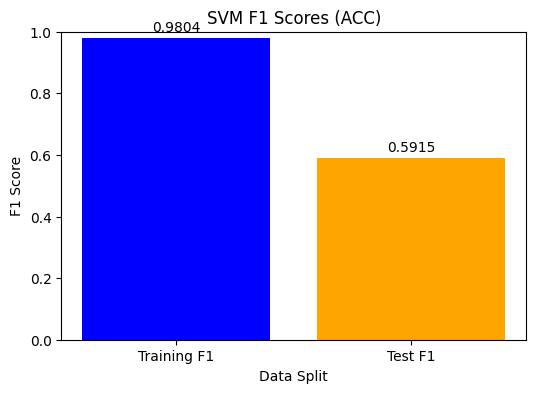

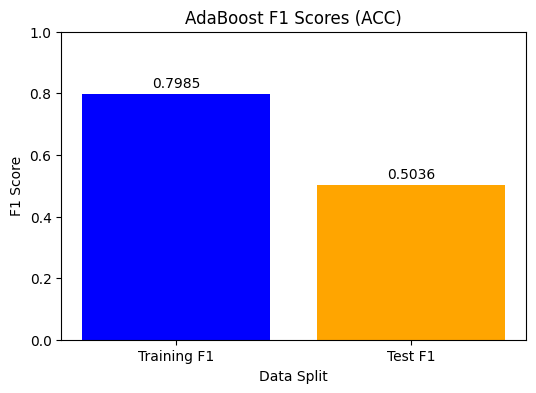

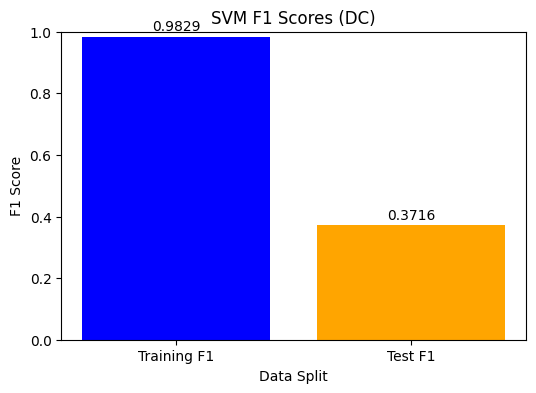

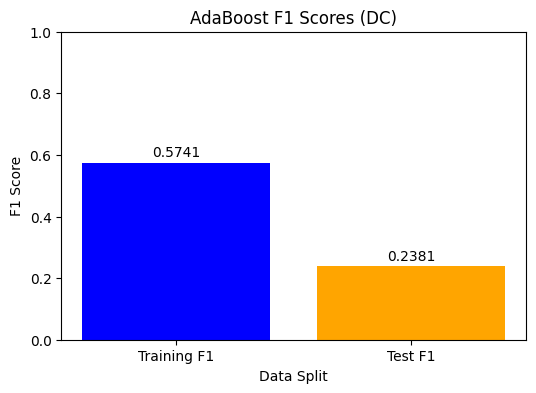


--- Analysis ---
F1 Scores for ACC Modality:
  SVM (Training): 0.9804, SVM (Test): 0.5915
  AdaBoost (Training): 0.7985, AdaBoost (Test): 0.5036

F1 Scores for DC Modality:
  SVM (Training): 0.9829, SVM (Test): 0.3716
  AdaBoost (Training): 0.5741, AdaBoost (Test): 0.2381


In [ ]:
# 4.1

# 4.1: Decision-Level Fusion for Multimodal Classification

# --- Hyperparameter Tuning and Training for SVM and AdaBoost ---
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, param_grid, classifier_type, modality):
    """
    Performs hyperparameter tuning, trains the classifier, and evaluates it on the test set.

    Args:
        X_train: Training data features.
        y_train: Training data labels.
        X_test: Test data features.
        y_test: Test data labels.
        param_grid: Dictionary of hyperparameters for GridSearchCV.
        classifier_type: Classifier type ("SVM" or "AdaBoost").
        modality: Modality being trained ("ACC" or "DC").

    Returns:
        The trained classifier and its evaluation metrics (training and test F1 scores).
    """
    print(f"Range of {classifier_type} ({modality}) - Training Data: min={X_train.min()}, max={X_train.max()}")
    print(f"Range of {classifier_type} ({modality}) - Test Data: min={X_test.min()}, max={X_test.max()}")

    if classifier_type == "SVM":
        classifier = SVC(kernel="rbf", probability=True)
    elif classifier_type == "AdaBoost":
        classifier = AdaBoostClassifier(random_state=0)
    else:
        raise ValueError("Invalid classifier type. Choose 'SVM' or 'AdaBoost'.")

    # Perform GridSearchCV
    grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring="f1_macro")
    grid_search.fit(X_train, y_train)

    # Print best parameters and score
    print(f"\n--- {classifier_type} ({modality}) ---")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best F1 score (training): {grid_search.best_score_:.4f}")

    # Train final classifier with best parameters
    best_classifier = grid_search.best_estimator_
    best_classifier.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = best_classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    f1_test = f1_score(y_test, y_pred, average="macro")

    # Print evaluation results
    print(f"\n--- {classifier_type} ({modality}) - Test Set ---")
    print("Confusion Matrix:")
    print(cm)
    print(f"F1 Score (test): {f1_test:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({classifier_type} - {modality})")
    plt.show()

    return best_classifier, grid_search.best_score_, f1_test

# --- Normalize Data ---
def normalize_data(X_train, X_test, y_train, y_test):
    """
    Normalizes data using MinMaxScaler along each axis (x and y).

    Args:
        X_train: Training data features.
        X_test: Test data features.
        y_train: Training data labels.
        y_test: Test data labels.

    Returns:
        Normalized training and testing data for features and labels.
    """
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Normalize features (x-axis)
    X_train_normalized_x = scaler_x.fit_transform(X_train)
    X_test_normalized_x = scaler_x.transform(X_test)

    # Normalize labels (y-axis)
    y_train_normalized = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_normalized = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    return X_train_normalized_x, X_test_normalized_x, y_train_normalized, y_test_normalized

# --- Plot F1 Scores for Overfitting Detection ---
def plot_f1_scores(f1_train, f1_test, modality, classifier_type):
    """
    Plots training and test F1 scores to detect potential overfitting.

    Args:
        f1_train: F1 score on training data.
        f1_test: F1 score on test data.
        modality: Sensor modality ("ACC" or "DC").
        classifier_type: Classifier type ("SVM" or "AdaBoost").
    """
    labels = ["Training F1", "Test F1"]
    scores = [f1_train, f1_test]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, scores, color=["blue", "orange"])
    plt.ylim(0, 1)
    plt.title(f"{classifier_type} F1 Scores ({modality})")
    plt.ylabel("F1 Score")
    plt.xlabel("Data Split")
    for i, score in enumerate(scores):
        plt.text(i, score + 0.02, f"{score:.4f}", ha="center", fontsize=10)
    plt.show()

# --- Filter Data for Each Modality ---
def filter_by_sensor(df, sensor_type):
    """
    Filters the given DataFrame by the specified sensor type.

    Args:
        df: The DataFrame to filter.
        sensor_type: The type of sensor to filter by ("acc" or "dc").

    Returns:
        Filtered DataFrame.
    """
    return df[df["sensor"] == sensor_type]

"""
    Main Code
"""

# Filter training and testing data for each modality
df_train_acc = filter_by_sensor(df_train_transformed_acc, "acc")
df_test_acc = filter_by_sensor(df_test_transformed_acc, "acc")
df_train_dc = filter_by_sensor(df_train_transformed_dc, "dc")
df_test_dc = filter_by_sensor(df_test_transformed_dc, "dc")

# Prepare data for accelerometer modality (ACC)
X_train_acc = np.array(df_train_acc["df"].tolist())
y_train_acc = df_train_acc["exercise_id"].values
X_test_acc = np.array(df_test_acc["df"].tolist())
y_test_acc = df_test_acc["exercise_id"].values

# Normalize ACC data
X_train_acc, X_test_acc, y_train_acc, y_test_acc = normalize_data(X_train_acc, X_test_acc, y_train_acc, y_test_acc)

# Prepare data for depth camera modality (DC)
X_train_dc = np.array(df_train_dc["df"].tolist())
y_train_dc = df_train_dc["exercise_id"].values
X_test_dc = np.array(df_test_dc["df"].tolist())
y_test_dc = df_test_dc["exercise_id"].values

# Normalize DC data
X_train_dc, X_test_dc, y_train_dc, y_test_dc = normalize_data(X_train_dc, X_test_dc, y_train_dc, y_test_dc)

# Map string labels to numerical labels
def map_labels(y_train, y_test):
    label_mapping = {label: i for i, label in enumerate(np.unique(y_train))}
    y_train_numeric = np.array([label_mapping[label] for label in y_train])
    y_test_numeric = np.array([label_mapping[label] for label in y_test])
    return y_train_numeric, y_test_numeric, label_mapping

# Map labels for ACC modality
y_train_acc_numeric, y_test_acc_numeric, label_mapping_acc = map_labels(y_train_acc, y_test_acc)

# Map labels for DC modality
y_train_dc_numeric, y_test_dc_numeric, label_mapping_dc = map_labels(y_train_dc, y_test_dc)

# Define parameter grids
param_grid_svm = {"C": [0.1, 1.0, 10.0, 100.0], "gamma": [0.1, 0.25, 0.5, 0.75, 1.0, 2.0]}
param_grid_ada = {"n_estimators": [50, 100, 500, 1000], "learning_rate": [0.1, 0.25, 0.5, 0.75, 1.0]}

# Train and evaluate classifiers for ACC modality
svm_acc, f1_train_svm_acc, f1_test_svm_acc = train_and_evaluate_classifier(
    X_train_acc, y_train_acc_numeric, X_test_acc, y_test_acc_numeric, param_grid_svm, "SVM", "ACC")
ada_acc, f1_train_ada_acc, f1_test_ada_acc = train_and_evaluate_classifier(
    X_train_acc, y_train_acc_numeric, X_test_acc, y_test_acc_numeric, param_grid_ada, "AdaBoost", "ACC")

# Train and evaluate classifiers for DC modality
svm_dc, f1_train_svm_dc, f1_test_svm_dc = train_and_evaluate_classifier(
    X_train_dc, y_train_dc_numeric, X_test_dc, y_test_dc_numeric, param_grid_svm, "SVM", "DC")
ada_dc, f1_train_ada_dc, f1_test_ada_dc = train_and_evaluate_classifier(
    X_train_dc, y_train_dc_numeric, X_test_dc, y_test_dc_numeric, param_grid_ada, "AdaBoost", "DC")

# Plot F1 Scores for all classifiers and modalities
plot_f1_scores(f1_train_svm_acc, f1_test_svm_acc, "ACC", "SVM")
plot_f1_scores(f1_train_ada_acc, f1_test_ada_acc, "ACC", "AdaBoost")
plot_f1_scores(f1_train_svm_dc, f1_test_svm_dc, "DC", "SVM")
plot_f1_scores(f1_train_ada_dc, f1_test_ada_dc, "DC", "AdaBoost")

# --- Analysis ---
print("\n--- Analysis ---")
print("F1 Scores for ACC Modality:")
print(f"  SVM (Training): {f1_train_svm_acc:.4f}, SVM (Test): {f1_test_svm_acc:.4f}")
print(f"  AdaBoost (Training): {f1_train_ada_acc:.4f}, AdaBoost (Test): {f1_test_ada_acc:.4f}")

print("\nF1 Scores for DC Modality:")
print(f"  SVM (Training): {f1_train_svm_dc:.4f}, SVM (Test): {f1_test_svm_dc:.4f}")
print(f"  AdaBoost (Training): {f1_train_ada_dc:.4f}, AdaBoost (Test): {f1_test_ada_dc:.4f}")

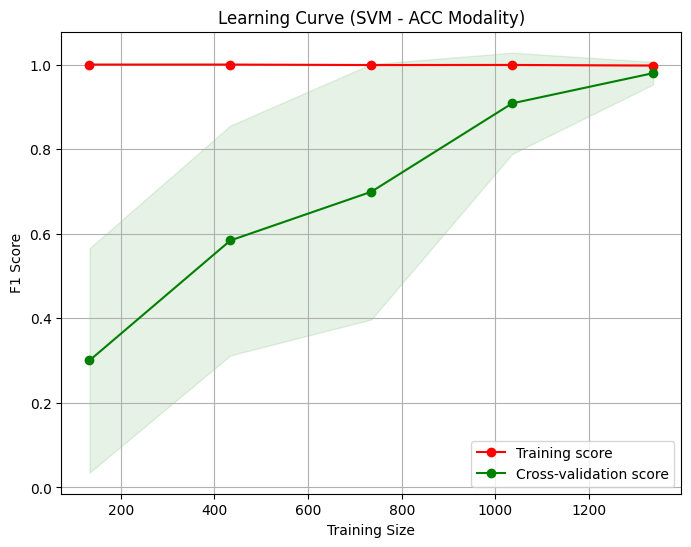

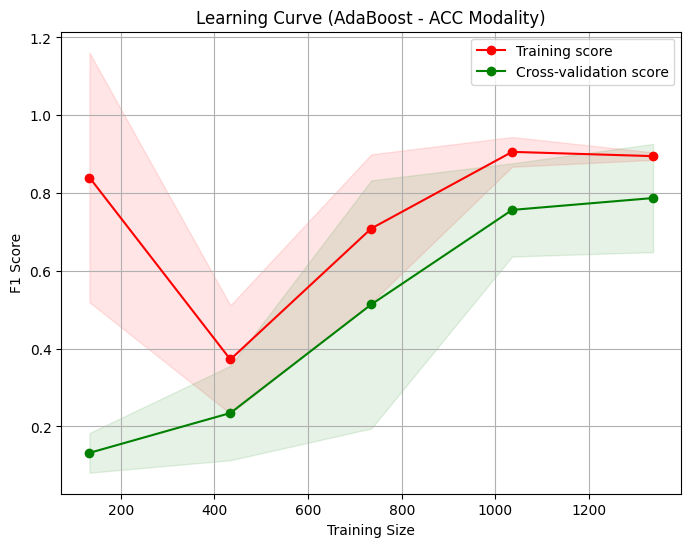

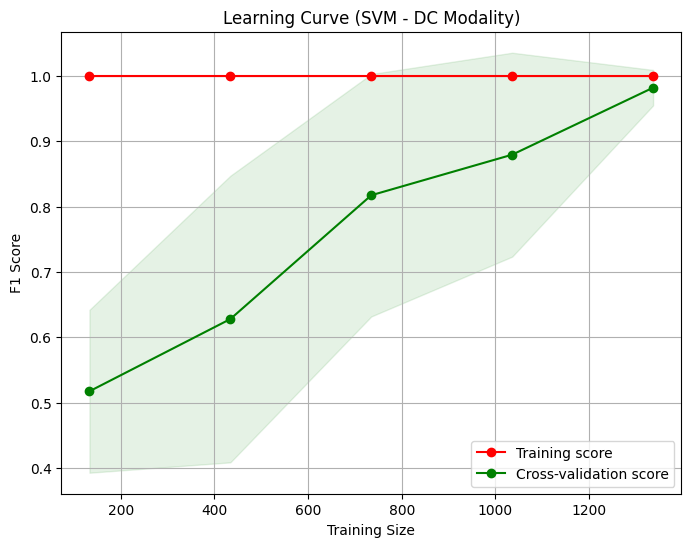

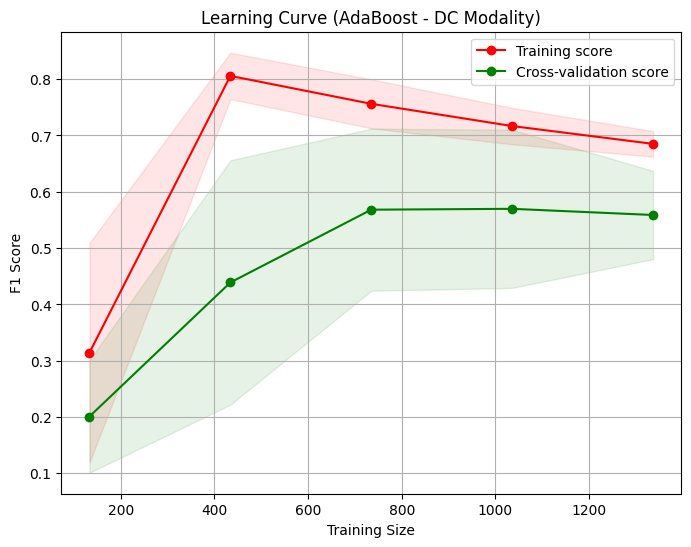

In [ ]:
def plot_learning_curve(estimator, X, y, title, cv, scoring="f1_macro", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Plots the learning curve for a given estimator.

    Args:
        estimator: The machine learning model to evaluate.
        X: Features dataset.
        y: Labels dataset.
        title: Title of the plot.
        cv: Cross-validation splitting strategy.
        scoring: Scoring method (default is "f1_macro").
        n_jobs: Number of jobs to run in parallel.
        train_sizes: Relative or absolute numbers of training examples to use to generate the curve.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("F1 Score")
    plt.grid()

    # Plot the learning curve
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# --- Plot Learning Curves for Each Classifier and Modality ---
# SVM for ACC modality
plot_learning_curve(
    SVC(kernel="rbf", C=100.0, gamma=0.75),
    X_train_acc, y_train_acc_numeric,
    title="Learning Curve (SVM - ACC Modality)", cv=10
)

# AdaBoost for ACC modality
plot_learning_curve(
    AdaBoostClassifier(random_state=0, n_estimators=1000, learning_rate=1.0),
    X_train_acc, y_train_acc_numeric,
    title="Learning Curve (AdaBoost - ACC Modality)", cv=10
)

# SVM for DC modality
plot_learning_curve(
    SVC(kernel="rbf", C=100.0, gamma=0.75),
    X_train_dc, y_train_dc_numeric,
    title="Learning Curve (SVM - DC Modality)", cv=10
)

# AdaBoost for DC modality
plot_learning_curve(
    AdaBoostClassifier(random_state=0, n_estimators=1000, learning_rate=1.0),
    X_train_dc, y_train_dc_numeric,
    title="Learning Curve (AdaBoost - DC Modality)", cv=10
)

<a id='task4'></a>
<div class=" alert alert-warning">


<p> <b>4.2</b> Predict probabilistic outputs of each trained classifier for both modalities using the test set. </p>
<br>
    
</div>

In [ ]:
# 4.2

# --- Predict Probabilistic Outputs ---
def predict_probabilities(classifier, X_test, modality, classifier_type):
    """
    Predicts probabilistic outputs for the given classifier.

    Args:
        classifier: The trained classifier.
        X_test: Test data features.
        modality: Sensor modality ("ACC" or "DC").
        classifier_type: Classifier type ("SVM" or "AdaBoost").

    Returns:
        Probabilistic outputs as a NumPy array.
    """
    probabilities = classifier.predict_proba(X_test)

    print(f"\n--- Probabilistic Outputs ({classifier_type} - {modality}) ---")
    print(f"Shape of probabilistic outputs: {probabilities.shape}")

    return probabilities

# --- Main Code ---

# Predict probabilistic outputs for ACC modality
prob_svm_acc = predict_probabilities(svm_acc, X_test_acc, "ACC", "SVM")
prob_ada_acc = predict_probabilities(ada_acc, X_test_acc, "ACC", "AdaBoost")

# Predict probabilistic outputs for DC modality
prob_svm_dc = predict_probabilities(svm_dc, X_test_dc, "DC", "SVM")
prob_ada_dc = predict_probabilities(ada_dc, X_test_dc, "DC", "AdaBoost")

# --- Analysis ---

print("\n--- Analysis ---")
print("Probabilistic Outputs Shape:")
print(f"  SVM (ACC): {prob_svm_acc.shape}")
print(f"  AdaBoost (ACC): {prob_ada_acc.shape}")
print(f"  SVM (DC): {prob_svm_dc.shape}")
print(f"  AdaBoost (DC): {prob_ada_dc.shape}")

# --- Example of Probabilistic Outputs ---
example_idx = 0
print("\nExample of Probabilistic Outputs for the First Test Instance:")
print(f"  SVM (ACC): {prob_svm_acc[example_idx]}")
print(f"  AdaBoost (ACC): {prob_ada_acc[example_idx]}")
print(f"  SVM (DC): {prob_svm_dc[example_idx]}")
print(f"  AdaBoost (DC): {prob_ada_dc[example_idx]}")


--- Probabilistic Outputs (SVM - ACC) ---
Shape of probabilistic outputs: (598, 7)

--- Probabilistic Outputs (AdaBoost - ACC) ---
Shape of probabilistic outputs: (598, 7)

--- Probabilistic Outputs (SVM - DC) ---
Shape of probabilistic outputs: (598, 7)

--- Probabilistic Outputs (AdaBoost - DC) ---
Shape of probabilistic outputs: (598, 7)

--- Analysis ---
Probabilistic Outputs Shape:
  SVM (ACC): (598, 7)
  AdaBoost (ACC): (598, 7)
  SVM (DC): (598, 7)
  AdaBoost (DC): (598, 7)

Example of Probabilistic Outputs for the First Test Instance:
  SVM (ACC): [5.19780805e-02 3.08616814e-03 8.75097312e-04 5.59851129e-03
 1.02323131e-02 4.81130091e-02 8.80116821e-01]
  AdaBoost (ACC): [0.14537464 0.14231507 0.14234312 0.13903    0.14324888 0.1427876
 0.14490069]
  SVM (DC): [0.15978439 0.0279019  0.02113361 0.12333676 0.34375178 0.10486802
 0.21922354]
  AdaBoost (DC): [0.14456608 0.14369303 0.14383967 0.14531416 0.14440613 0.13909285
 0.13908808]



--- Spread of Probabilities (SVM - ACC) ---
Max probabilities (mean): 0.8244
Max probabilities (std): 0.1896
Average probabilities per class: [0.11992759 0.22737906 0.02666438 0.13338437 0.12556643 0.20077765
 0.16630053]


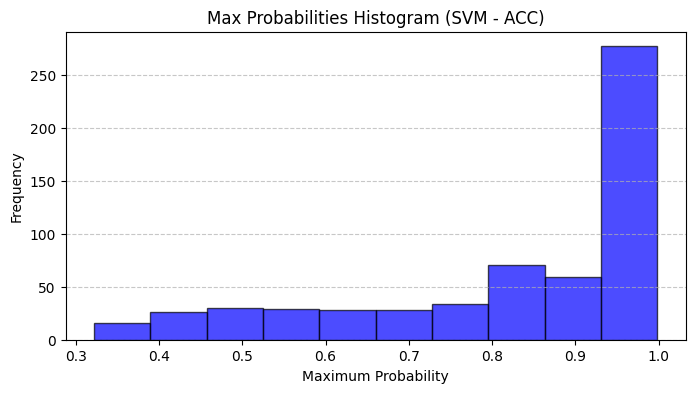

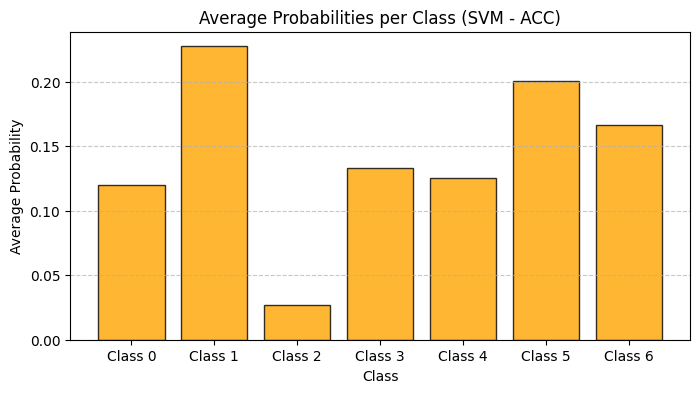


--- Spread of Probabilities (AdaBoost - ACC) ---
Max probabilities (mean): 0.1453
Max probabilities (std): 0.0001
Average probabilities per class: [0.14053106 0.14408758 0.14291621 0.13977116 0.14400267 0.14408099
 0.14461032]


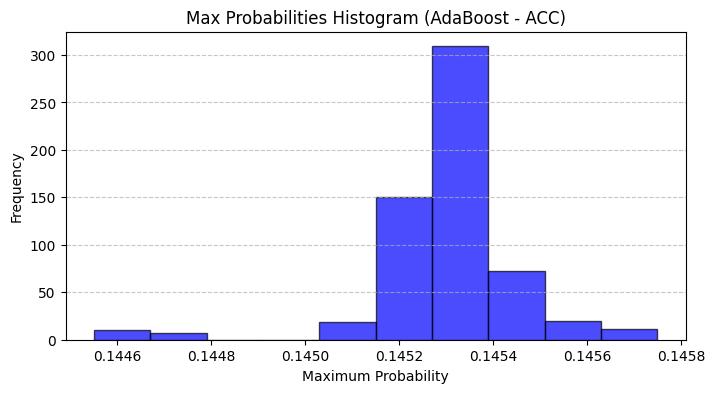

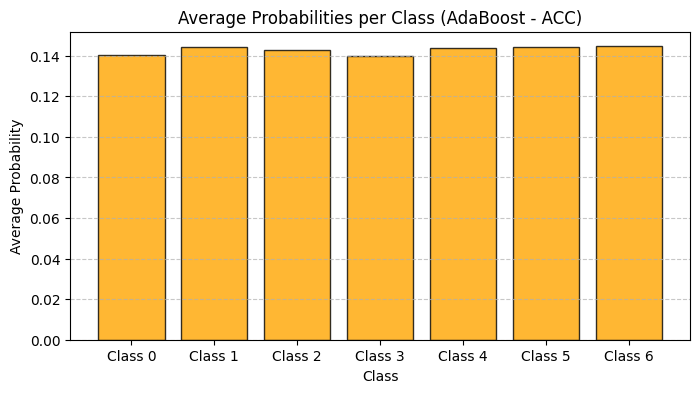


--- Spread of Probabilities (SVM - DC) ---
Max probabilities (mean): 0.7283
Max probabilities (std): 0.2259
Average probabilities per class: [0.41764913 0.10902476 0.0484018  0.04886047 0.0452826  0.06178718
 0.26899406]


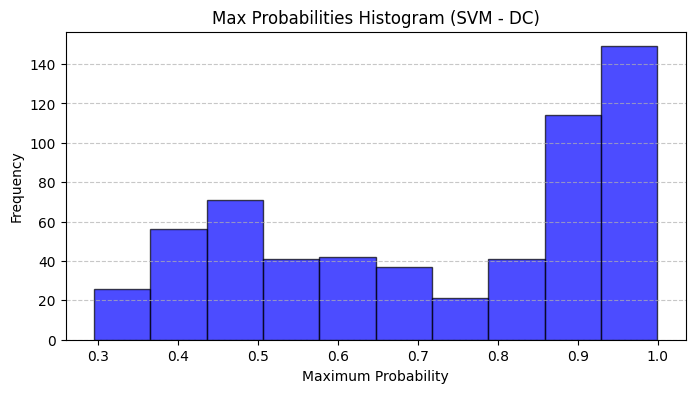

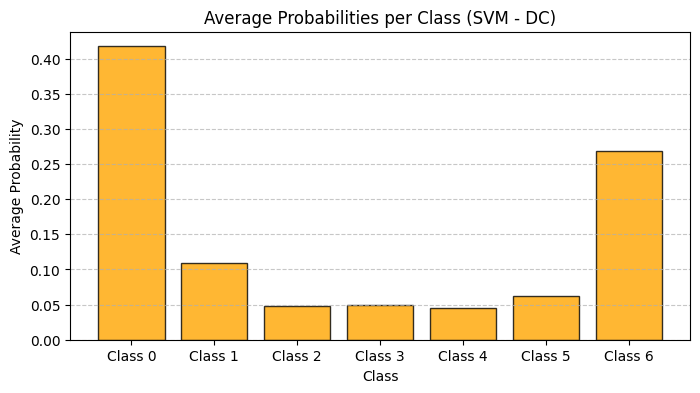


--- Spread of Probabilities (AdaBoost - DC) ---
Max probabilities (mean): 0.1460
Max probabilities (std): 0.0005
Average probabilities per class: [0.14502272 0.1437342  0.14335579 0.14401527 0.14163684 0.14111731
 0.14111788]


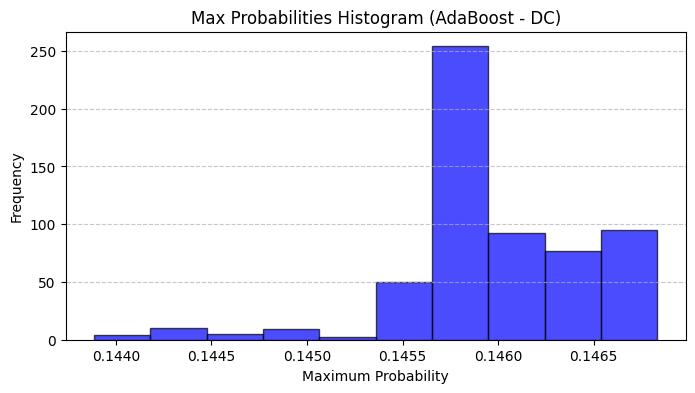

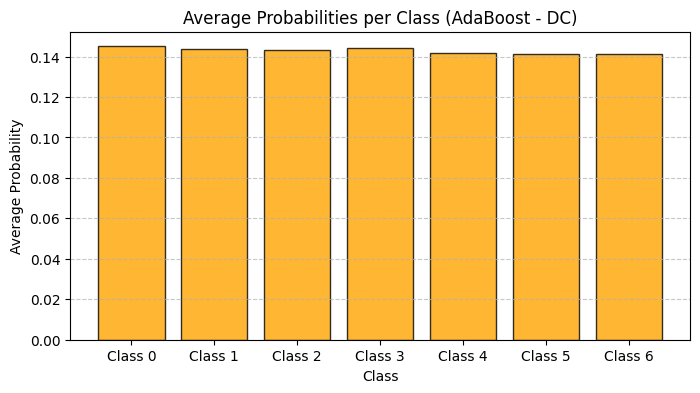

In [ ]:
# --- Analyze Spread of Probabilities ---

def analyze_probability_distribution(probabilities, modality, classifier_type, class_labels):
    """
    Analyzes and visualizes the spread of probabilities.

    Args:
        probabilities: Probabilistic outputs as a NumPy array.
        modality: Sensor modality ("ACC" or "DC").
        classifier_type: Classifier type ("SVM" or "AdaBoost").
        class_labels: List of class labels.

    Returns:
        None
    """
    max_probs = probabilities.max(axis=1)  # Maximum probability for each test instance
    avg_probs = probabilities.mean(axis=0)  # Average probability for each class

    print(f"\n--- Spread of Probabilities ({classifier_type} - {modality}) ---")
    print(f"Max probabilities (mean): {max_probs.mean():.4f}")
    print(f"Max probabilities (std): {max_probs.std():.4f}")
    print(f"Average probabilities per class: {avg_probs}")

    # Plot histogram of maximum probabilities for test instances
    plt.figure(figsize=(8, 4))
    plt.hist(max_probs, bins=10, color="blue", alpha=0.7, edgecolor="black")
    plt.title(f"Max Probabilities Histogram ({classifier_type} - {modality})")
    plt.xlabel("Maximum Probability")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # Plot average probabilities for each class
    plt.figure(figsize=(8, 4))
    plt.bar(class_labels, avg_probs, color="orange", alpha=0.8, edgecolor="black")
    plt.title(f"Average Probabilities per Class ({classifier_type} - {modality})")
    plt.xlabel("Class")
    plt.ylabel("Average Probability")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# --- Main Code ---

# Class labels (numeric or string based on your dataset)
class_labels_acc = [f"Class {i}" for i in range(prob_svm_acc.shape[1])]
class_labels_dc = [f"Class {i}" for i in range(prob_svm_dc.shape[1])]

# Analyze probabilities for SVM and AdaBoost (ACC modality)
analyze_probability_distribution(prob_svm_acc, "ACC", "SVM", class_labels_acc)
analyze_probability_distribution(prob_ada_acc, "ACC", "AdaBoost", class_labels_acc)

# Analyze probabilities for SVM and AdaBoost (DC modality)
analyze_probability_distribution(prob_svm_dc, "DC", "SVM", class_labels_dc)
analyze_probability_distribution(prob_ada_dc, "DC", "AdaBoost", class_labels_dc)


<a id='part4'></a>
<div class=" alert alert-warning">

### **4.3 Decision-Level Fusion Using Probabilistic Outputs**  

In this section, we will **combine the probabilistic outputs** of different modalities using fixed classification rules. The goal is to improve classification performance by leveraging information from both accelerometer and depth image modalities.  

#### **Fusion Methods**  
The following **fixed classification rules** will be used to combine the outputs:  

- **Max Rule**: Selects the highest probability among modalities.  
- **Min Rule**: Selects the lowest probability among modalities.  
- **Product Rule (Prod)**: Multiplies the probabilities from each modality.  
- **Sum Rule**: Averages the probabilities from both modalities.  

#### **Classifier Combinations**  
The fusion will be applied to different **base classifier combinations**, including:  

- **SVM (Accelerometer) + SVM (Depth Image)**  
- **AdaBoost (Accelerometer) + AdaBoost (Depth Image)**  
- **SVM (Accelerometer) + AdaBoost (Depth Image)**  
- **AdaBoost (Accelerometer) + SVM (Depth Image)**  

#### **Evaluation and Analysis**  
The final combined results will be evaluated and compared using:  

- **Confusion matrices**  
- **F1 scores**  
    
</div>


--- Combined Classifier (SVM_ACC + SVM_DC - Rule: max) ---
Confusion Matrix:
[[57  0  0  0  0  0 28]
 [ 7 30  0  0  1 23 23]
 [11 41  0  1  4 29  0]
 [ 8  0  0 64  0  2  6]
 [ 1  2  0  0 20  7 60]
 [68  7  0  0  0 13  0]
 [25  4  0  0  0  3 53]]
F1 Score: 0.3709


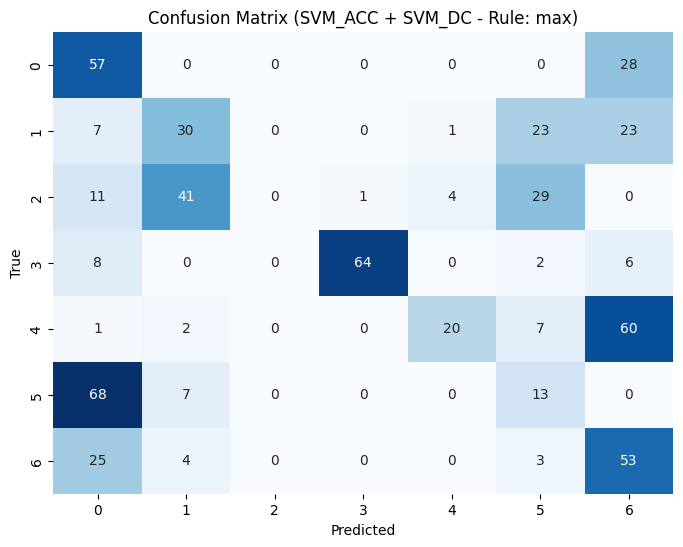


--- Combined Classifier (SVM_ACC + SVM_DC - Rule: min) ---
Confusion Matrix:
[[70  0  0  0  0  0 15]
 [29  4  0 26  1  2 22]
 [ 0 40  1  0 16  9 20]
 [ 7  0  0 64  0  0  9]
 [ 3 22  0  1  2  0 62]
 [33 20 13  1  0 13  8]
 [22  3  0  4  0  1 55]]
F1 Score: 0.2887


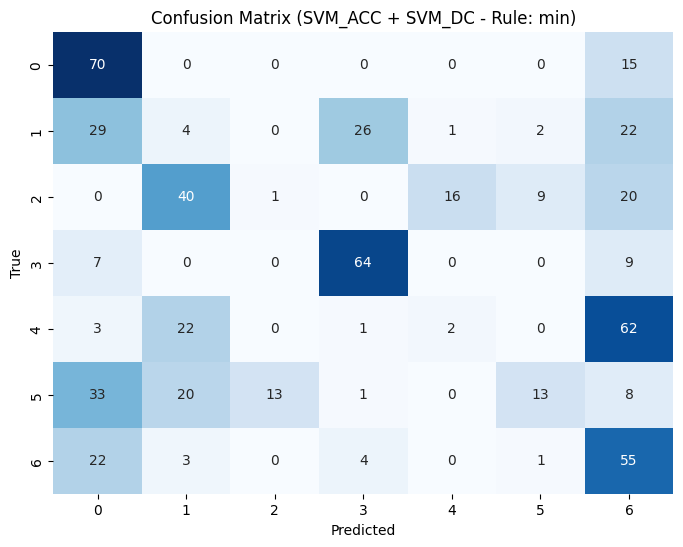


--- Combined Classifier (SVM_ACC + SVM_DC - Rule: prod) ---
Confusion Matrix:
[[57  0  0  0  0  0 28]
 [20 34  0  0  2 26  2]
 [ 0 42  0  0 15 29  0]
 [ 7  0  0 66  0  3  4]
 [ 0 11  0  0  5  7 67]
 [58 14  0  0  0 16  0]
 [24  5  0  0  0  1 55]]
F1 Score: 0.3500


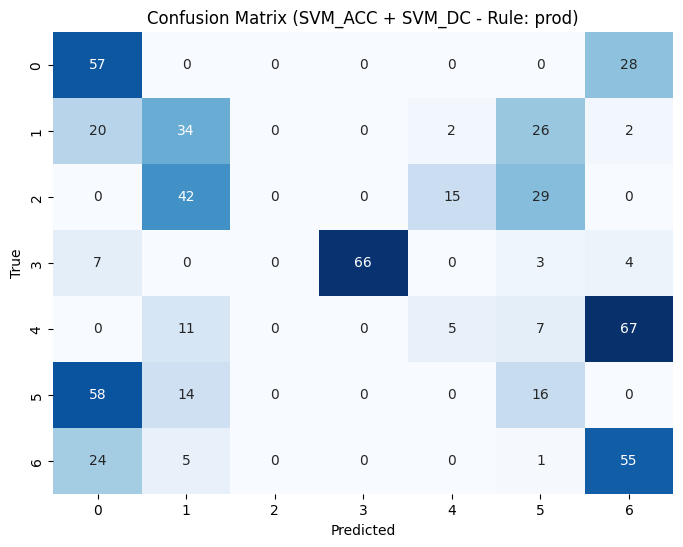


--- Combined Classifier (SVM_ACC + SVM_DC - Rule: sum) ---
Confusion Matrix:
[[57  0  0  0  0  0 28]
 [ 6 30  0  0  1 24 23]
 [ 7 43  0  1  6 29  0]
 [ 8  0  0 64  0  2  6]
 [ 1  2  0  0 18  7 62]
 [65  9  0  0  0 14  0]
 [25  5  0  0  0  2 53]]
F1 Score: 0.3675


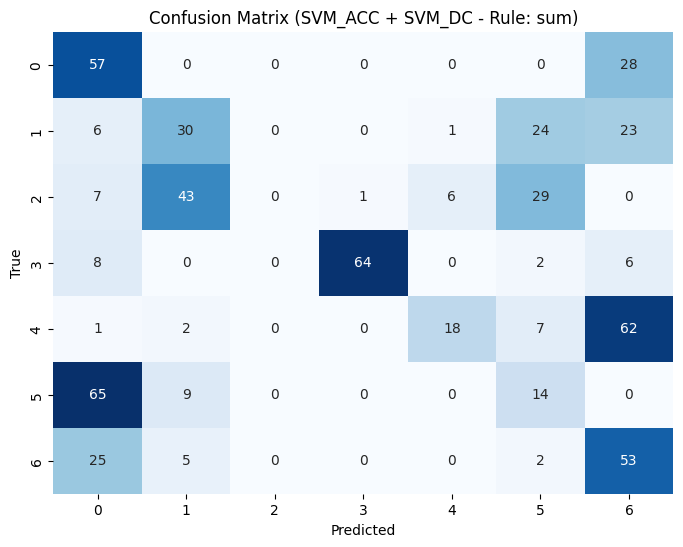


--- Combined Classifier (AdaBoost_ACC + AdaBoost_DC - Rule: max) ---
Confusion Matrix:
[[71  2  0  0  1  8  3]
 [55  0  0  0  0 29  0]
 [74  8  0  0  0  4  0]
 [64  0  0  0  0 16  0]
 [14  3  0  0  1 62 10]
 [70  1  0  8  0  9  0]
 [42  1  0  1  0 30 11]]
F1 Score: 0.0851


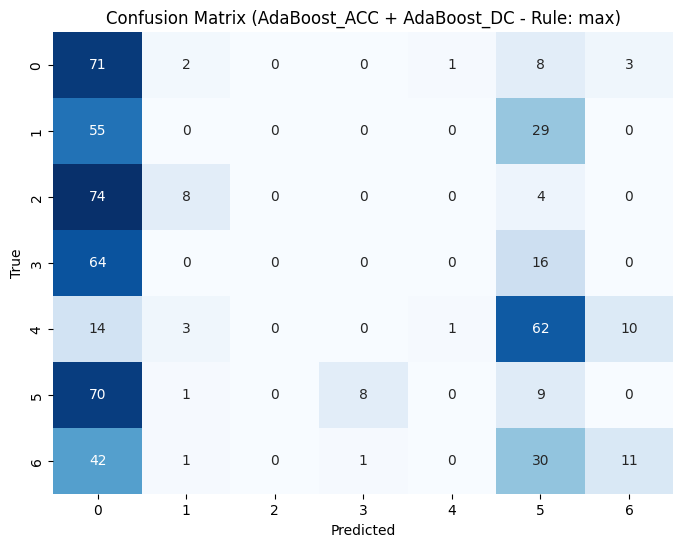


--- Combined Classifier (AdaBoost_ACC + AdaBoost_DC - Rule: min) ---
Confusion Matrix:
[[74  0  0  0  0  0 11]
 [ 0 51  4  0  0  0 29]
 [ 0 72  0  0 12  1  1]
 [26  0  0 38  0 10  6]
 [ 0 19  0  0  0  0 71]
 [ 0 79  0  0  0  9  0]
 [ 3 43  1  0  0  0 38]]
F1 Score: 0.3152


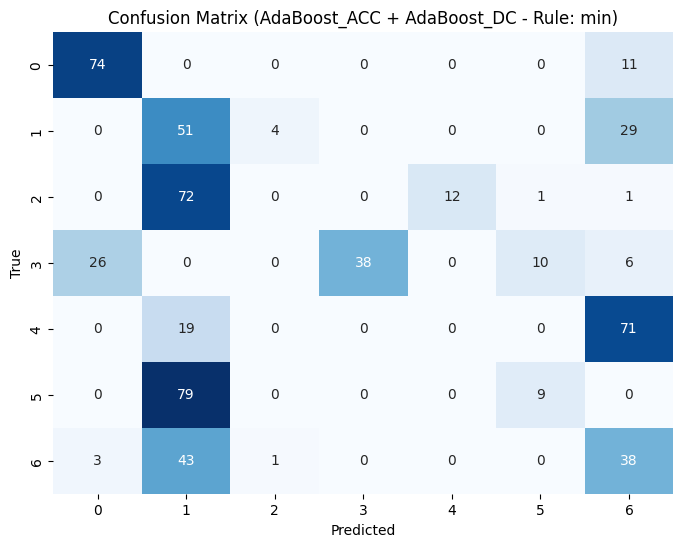


--- Combined Classifier (AdaBoost_ACC + AdaBoost_DC - Rule: prod) ---
Confusion Matrix:
[[74  0  0  0  0  0 11]
 [ 0 54  0  0  1  0 29]
 [ 0 72  0  0 12  1  1]
 [28  0  0 36  0 10  6]
 [ 0 19  0  0  0  0 71]
 [ 0 79  0  0  0  9  0]
 [ 3 43  1  0  0  0 38]]
F1 Score: 0.3128


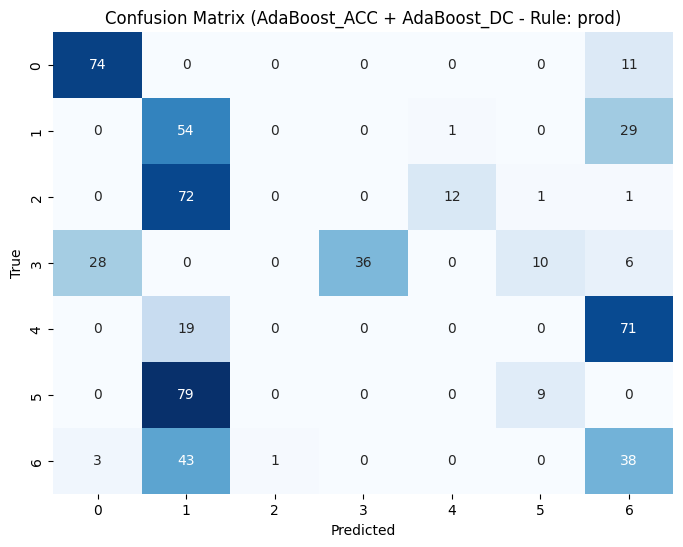


--- Combined Classifier (AdaBoost_ACC + AdaBoost_DC - Rule: sum) ---
Confusion Matrix:
[[74  0  0  0  0  0 11]
 [ 0 54  0  0  1  0 29]
 [ 0 72  0  0 12  1  1]
 [28  0  0 36  0 10  6]
 [ 0 19  0  0  0  0 71]
 [ 0 79  0  0  0  9  0]
 [ 3 43  1  0  0  0 38]]
F1 Score: 0.3128


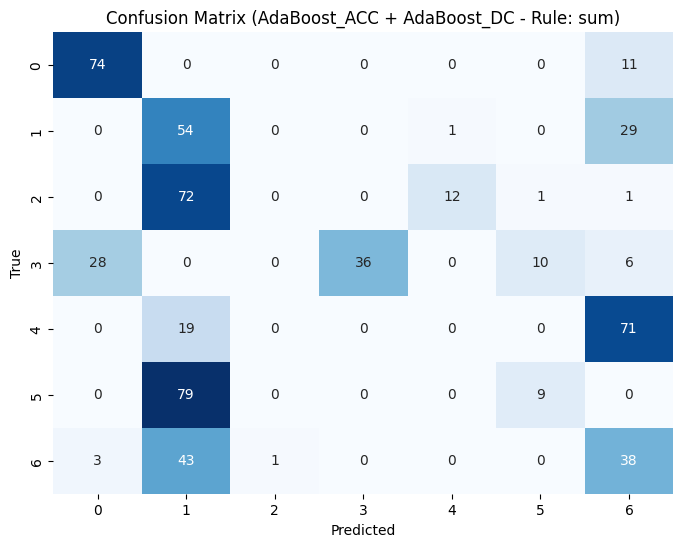


--- Combined Classifier (SVM_ACC + AdaBoost_DC - Rule: max) ---
Confusion Matrix:
[[57  0  0  0  0  0 28]
 [ 0 42  0  0 13 29  0]
 [ 0 42  0  0 15 29  0]
 [ 4  0  0 75  1  0  0]
 [ 0 26  0  0 61  0  3]
 [ 0 26  0  0  0 62  0]
 [ 0  7  0  0  0  4 74]]
F1 Score: 0.5943


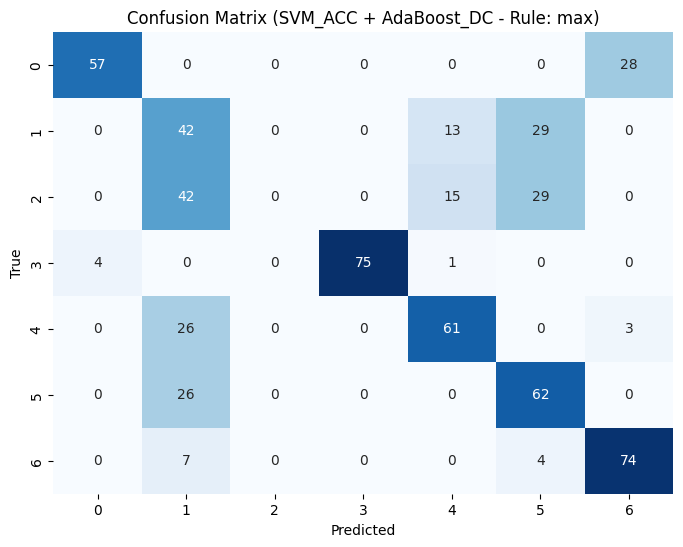


--- Combined Classifier (SVM_ACC + AdaBoost_DC - Rule: min) ---
Confusion Matrix:
[[62  0  0  0  0  1 22]
 [11 42  0  0  2 29  0]
 [ 0 45  2  0 10 29  0]
 [13  0  0 67  0  0  0]
 [ 0 29  0  0 54  0  7]
 [ 0 34  4  0  0 50  0]
 [ 3  4  0 19  0  7 52]]
F1 Score: 0.5322


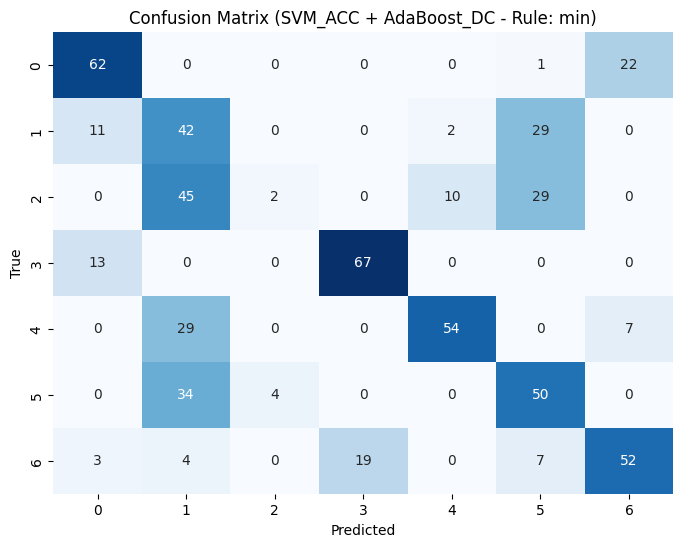


--- Combined Classifier (SVM_ACC + AdaBoost_DC - Rule: prod) ---
Confusion Matrix:
[[57  0  0  0  0  0 28]
 [ 0 42  0  0 13 29  0]
 [ 0 42  0  0 15 29  0]
 [ 4  0  0 75  1  0  0]
 [ 0 26  0  0 61  0  3]
 [ 0 26  0  0  0 62  0]
 [ 0  7  0  0  0  4 74]]
F1 Score: 0.5943


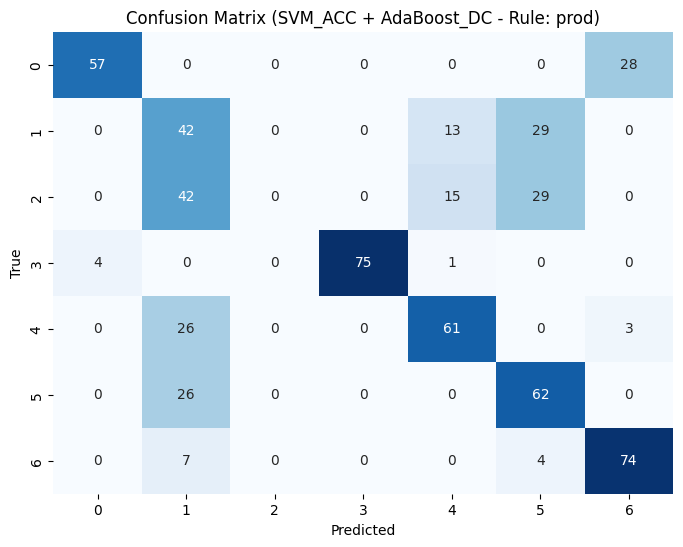


--- Combined Classifier (SVM_ACC + AdaBoost_DC - Rule: sum) ---
Confusion Matrix:
[[57  0  0  0  0  0 28]
 [ 0 42  0  0 13 29  0]
 [ 0 42  0  0 15 29  0]
 [ 4  0  0 75  1  0  0]
 [ 0 26  0  0 61  0  3]
 [ 0 26  0  0  0 62  0]
 [ 0  7  0  0  0  4 74]]
F1 Score: 0.5943


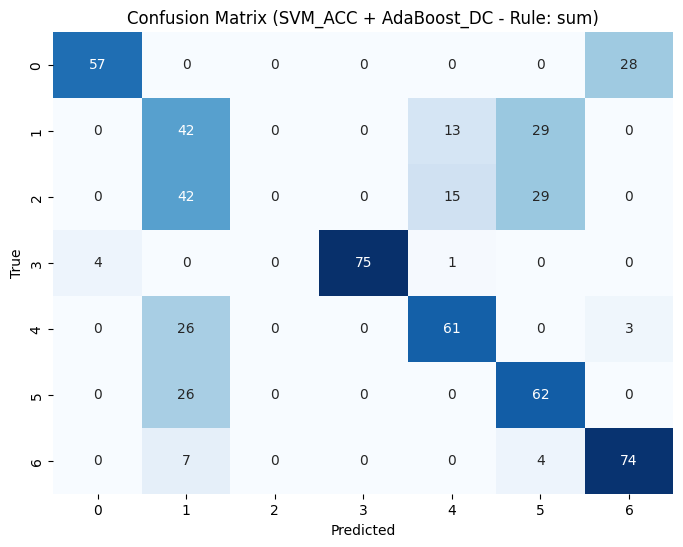


--- Combined Classifier (AdaBoost_ACC + SVM_DC - Rule: max) ---
Confusion Matrix:
[[25 27  0  0 28  0  5]
 [45  8  1  0  1  0 29]
 [47 22  3  9  5  0  0]
 [39  0 11  6  0 10 14]
 [18  0  0  0  0  9 63]
 [77  0  0  0  0  9  2]
 [33  5  0  0  0  0 47]]
F1 Score: 0.1385


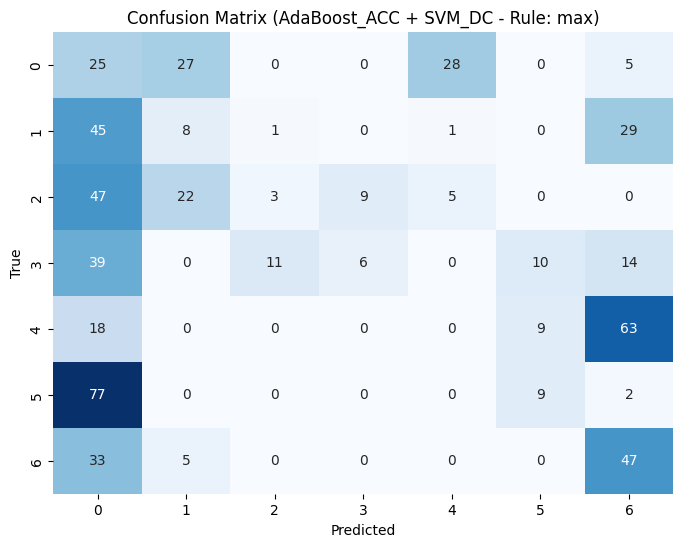


--- Combined Classifier (AdaBoost_ACC + SVM_DC - Rule: min) ---
Confusion Matrix:
[[68  8  0  0  0  0  9]
 [14 15  1  0 22  0 32]
 [11 47  7  9  8  0  4]
 [33 19 12  0  0 10  6]
 [ 0 16  0  0  2  7 65]
 [67  0  0  2  0  9 10]
 [27  3  0  0  0  0 55]]
F1 Score: 0.1912


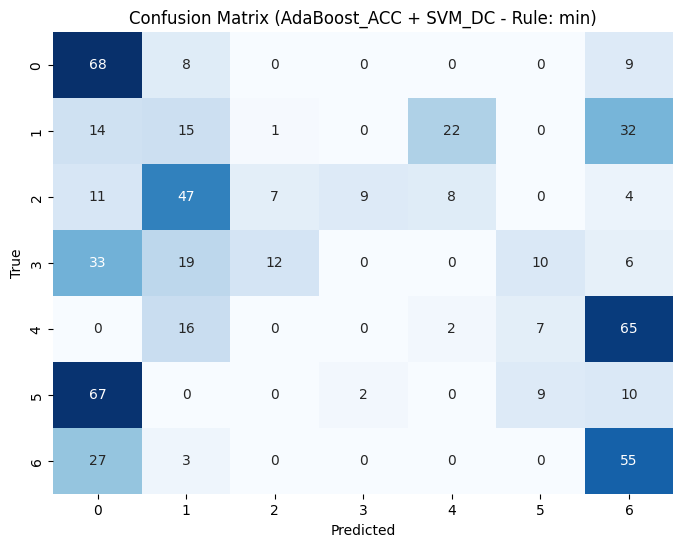


--- Combined Classifier (AdaBoost_ACC + SVM_DC - Rule: prod) ---
Confusion Matrix:
[[25 27  0  0 28  0  5]
 [45  8  1  0  1  0 29]
 [44 25  3  9  5  0  0]
 [39  0 11  6  0 10 14]
 [18  0  0  0  0  9 63]
 [77  0  0  0  0  9  2]
 [33  5  0  0  0  0 47]]
F1 Score: 0.1384


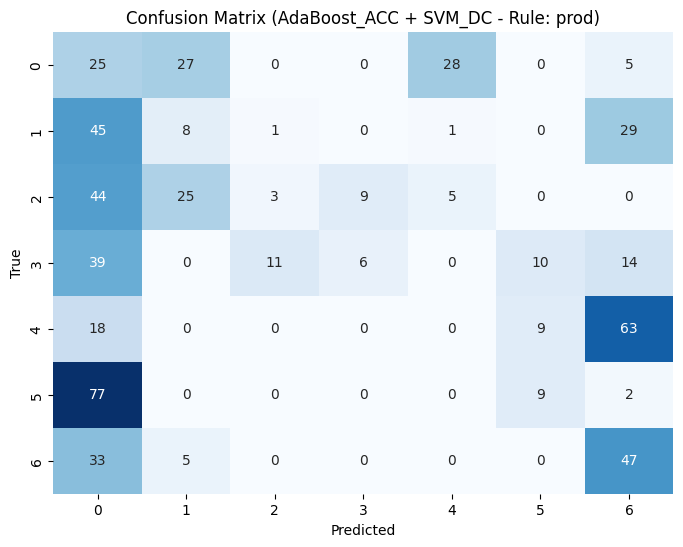


--- Combined Classifier (AdaBoost_ACC + SVM_DC - Rule: sum) ---
Confusion Matrix:
[[25 27  0  0 28  0  5]
 [45  8  1  0  1  0 29]
 [46 23  3  9  5  0  0]
 [39  0 11  6  0 10 14]
 [18  0  0  0  0  9 63]
 [77  0  0  0  0  9  2]
 [33  5  0  0  0  0 47]]
F1 Score: 0.1385


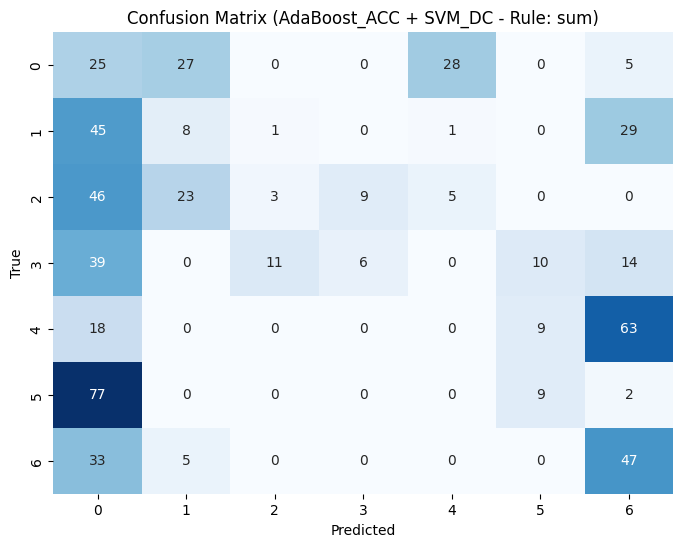


--- Final F1 Scores ---

SVM_ACC + SVM_DC:
  Rule: max, F1 Score: 0.3709
  Rule: min, F1 Score: 0.2887
  Rule: prod, F1 Score: 0.3500
  Rule: sum, F1 Score: 0.3675

AdaBoost_ACC + AdaBoost_DC:
  Rule: max, F1 Score: 0.0851
  Rule: min, F1 Score: 0.3152
  Rule: prod, F1 Score: 0.3128
  Rule: sum, F1 Score: 0.3128

SVM_ACC + AdaBoost_DC:
  Rule: max, F1 Score: 0.5943
  Rule: min, F1 Score: 0.5322
  Rule: prod, F1 Score: 0.5943
  Rule: sum, F1 Score: 0.5943

AdaBoost_ACC + SVM_DC:
  Rule: max, F1 Score: 0.1385
  Rule: min, F1 Score: 0.1912
  Rule: prod, F1 Score: 0.1384
  Rule: sum, F1 Score: 0.1385


In [ ]:
# 4.3

# --- Combine Probabilities by Rules ---
def combine_probabilities(prob1, prob2, rule):
    if rule == "max":
        return np.maximum(prob1, prob2)
    elif rule == "min":
        return np.minimum(prob1, prob2)
    elif rule == "prod":
        return prob1 * prob2
    elif rule == "sum":
        return prob1 + prob2
    else:
        raise ValueError("Invalid combination rule. Choose from 'max', 'min', 'prod', 'sum'.")

# --- Evaluate Combined Classifier ---
def evaluate_combined_classifier(prob_combined, y_test, rule, combination_name):
    y_pred_combined = np.argmax(prob_combined, axis=1)
    cm = confusion_matrix(y_test, y_pred_combined)
    f1 = f1_score(y_test, y_pred_combined, average="macro")

    print(f"\n--- Combined Classifier ({combination_name} - Rule: {rule}) ---")
    print("Confusion Matrix:")
    print(cm)
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({combination_name} - Rule: {rule})")
    plt.show()

    return f1

# --- Main Code ---
rules = ["max", "min", "prod", "sum"]
f1_scores = {}

# Combinations: SVM_ACC + SVM_DC, AdaBoost_ACC + AdaBoost_DC, etc.
combinations = [
    ("SVM_ACC", "SVM_DC", prob_svm_acc, prob_svm_dc),
    ("AdaBoost_ACC", "AdaBoost_DC", prob_ada_acc, prob_ada_dc),
    ("SVM_ACC", "AdaBoost_DC", prob_svm_acc, prob_ada_dc),
    ("AdaBoost_ACC", "SVM_DC", prob_ada_acc, prob_svm_dc),
]

for combination in combinations:
    name1, name2, prob1, prob2 = combination
    combination_name = f"{name1} + {name2}"
    f1_scores[combination_name] = {}

    for rule in rules:
        # Combine probabilities
        prob_combined = combine_probabilities(prob1, prob2, rule)

        # Evaluate combined classifier
        f1 = evaluate_combined_classifier(prob_combined, y_test_acc_numeric, rule, combination_name)
        f1_scores[combination_name][rule] = f1

# --- Print Final F1 Scores ---
print("\n--- Final F1 Scores ---")
for combination_name, scores in f1_scores.items():
    print(f"\n{combination_name}:")
    for rule, f1 in scores.items():
        print(f"  Rule: {rule}, F1 Score: {f1:.4f}")
